In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

### Get dissimilarities

#### Computation dynamics

In [3]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)
groups_base = ["untrained", "master"]
groups_selected = ["pretrain_basic_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]

In [4]:
df

model_type activation  hidden_size     lr  batch_size  \
0      leaky_gru       relu          128  0.010          64   
1      leaky_gru       relu          128  0.010          64   
2      leaky_gru       relu          128  0.010          64   
3      leaky_gru       relu          128  0.010          64   
4      leaky_gru       relu          128  0.010          64   
...          ...        ...          ...    ...         ...   
16795  leaky_rnn       tanh          256  0.001         128   
16796  leaky_rnn       tanh          256  0.001         128   
16797  leaky_rnn       tanh          256  0.001         128   
16798  leaky_rnn       tanh          256  0.001         128   
16799  leaky_rnn       tanh          256  0.001         128   

                  group1                       group2     measure  \
0              untrained                    untrained         cka   
1              untrained                master_frozen         cka   
2              untrained                       master         cka   
3              untrained        pretrain_basic_frozen         cka   
4              untrained         pretrain_anti_frozen         cka   
...                  ...                          ...         ...   
16795  pretrain_unfrozen        pretrain_delay_frozen  procrustes   
16796  pretrain_unfrozen   pretrain_basic_anti_frozen  procrustes   
16797  pretrain_unfrozen  pretrain_basic_delay_frozen  procrustes   
16798  pretrain_unfrozen              pretrain_frozen  procrustes   
16799  pretrain_unfrozen            pretrain_unfrozen  procrustes   

       dissimilarity  accuracy_1  accuracy_2  
0       0.000000e+00        -1.0   -1.000000  
1       2.831666e-01        -1.0    0.900244  
2       4.131438e-01        -1.0    1.000000  
3       4.158599e-01        -1.0    1.000000  
4       2.954913e-01        -1.0   -1.000000  
...              ...         ...         ...  
16795   6.247184e-01         1.0    1.000000  
16796   7.561041e-01         1.0    0.954836  
16797   6.349755e-01         1.0    0.499545  
16798   6.490532e-01         1.0    0.551069  
16799   5.612214e-08         1.0    1.000000  

[16800 rows x 11 columns]

In [5]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, axes = plt.subplots(
            nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            ax = axes[groups_base.index(group)]
            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group) &
                    (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette="Set2",
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

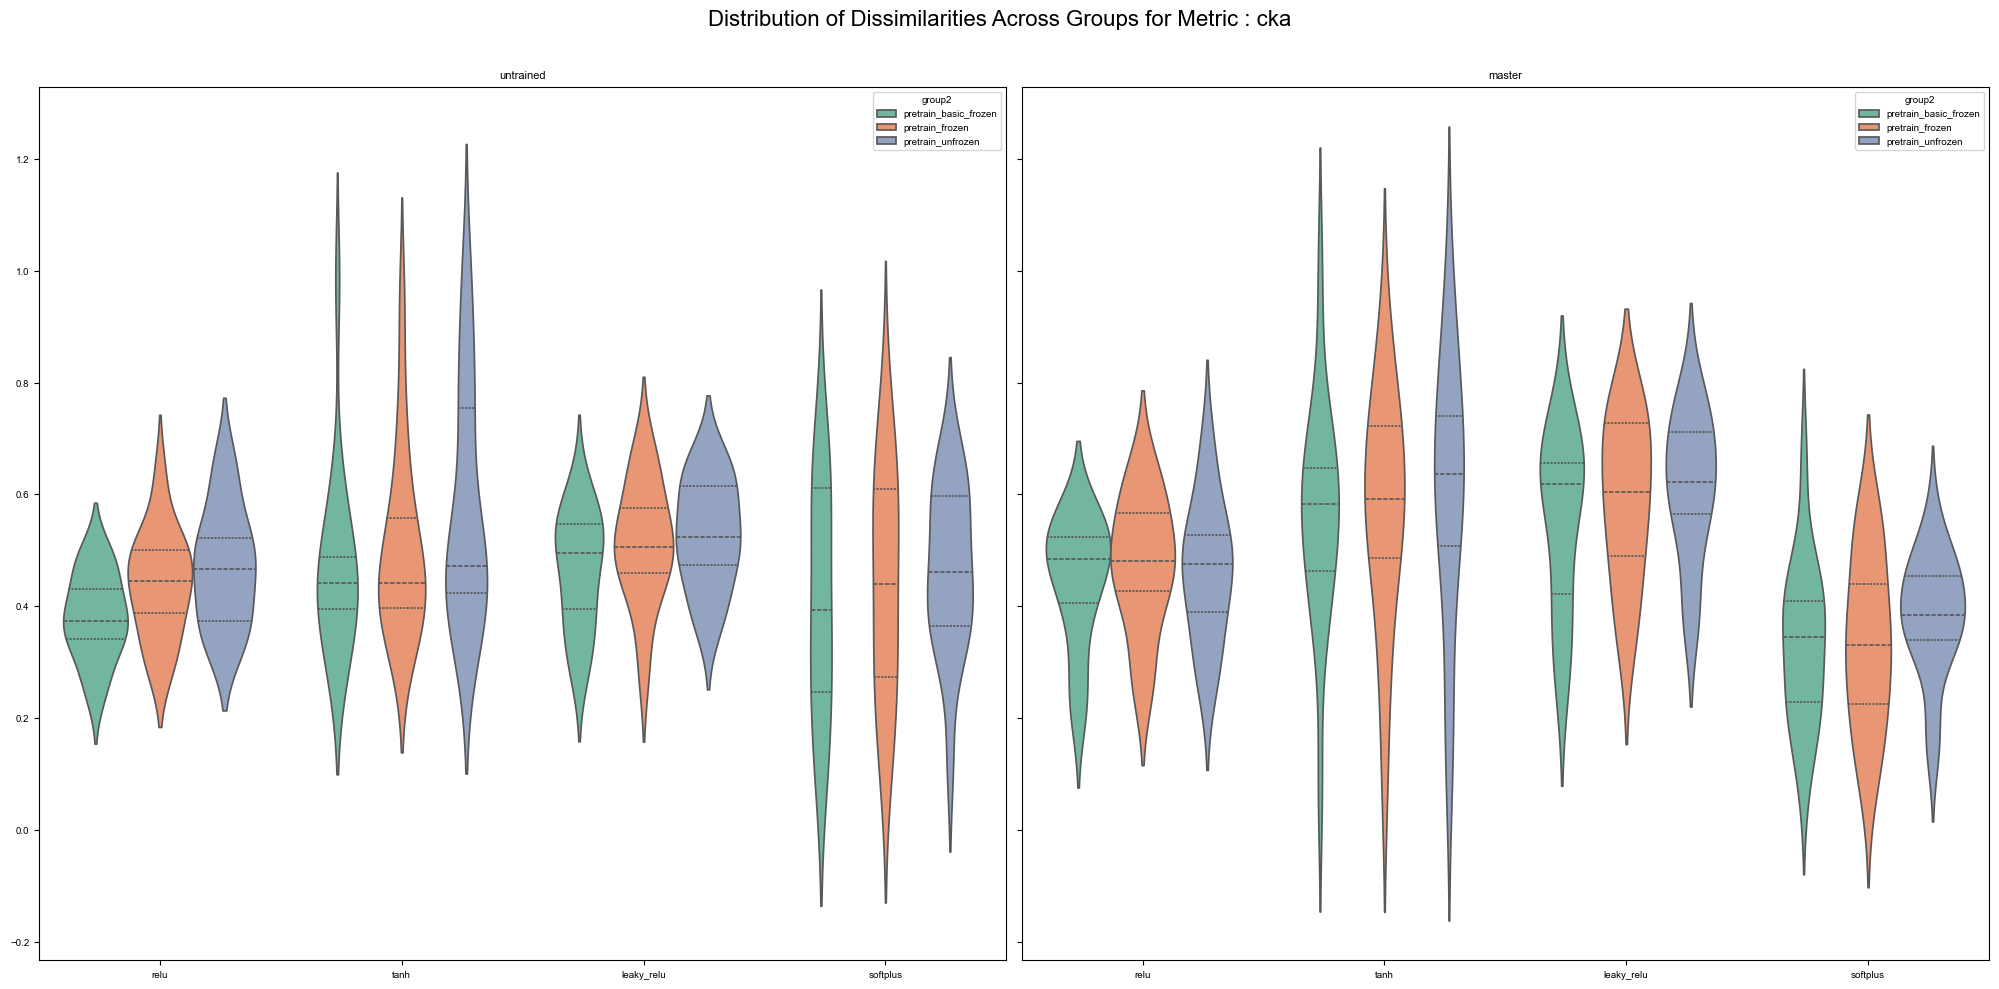

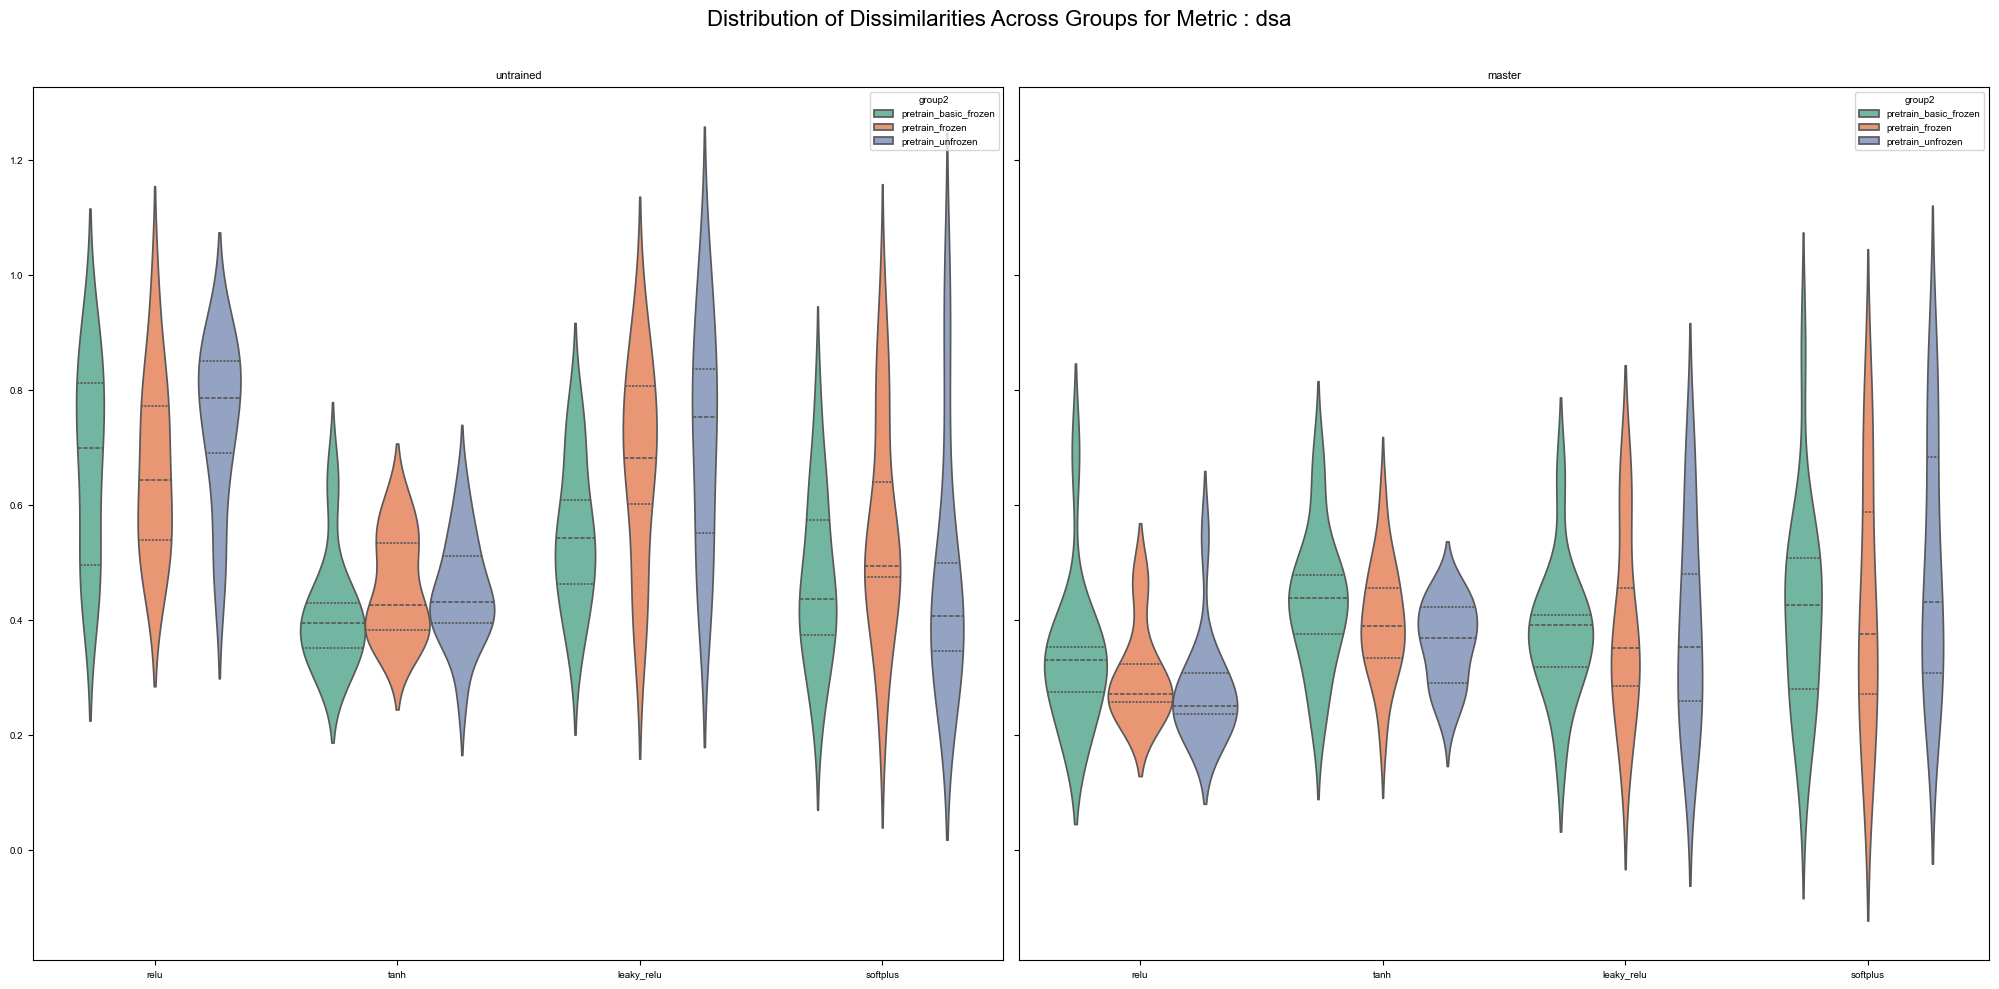

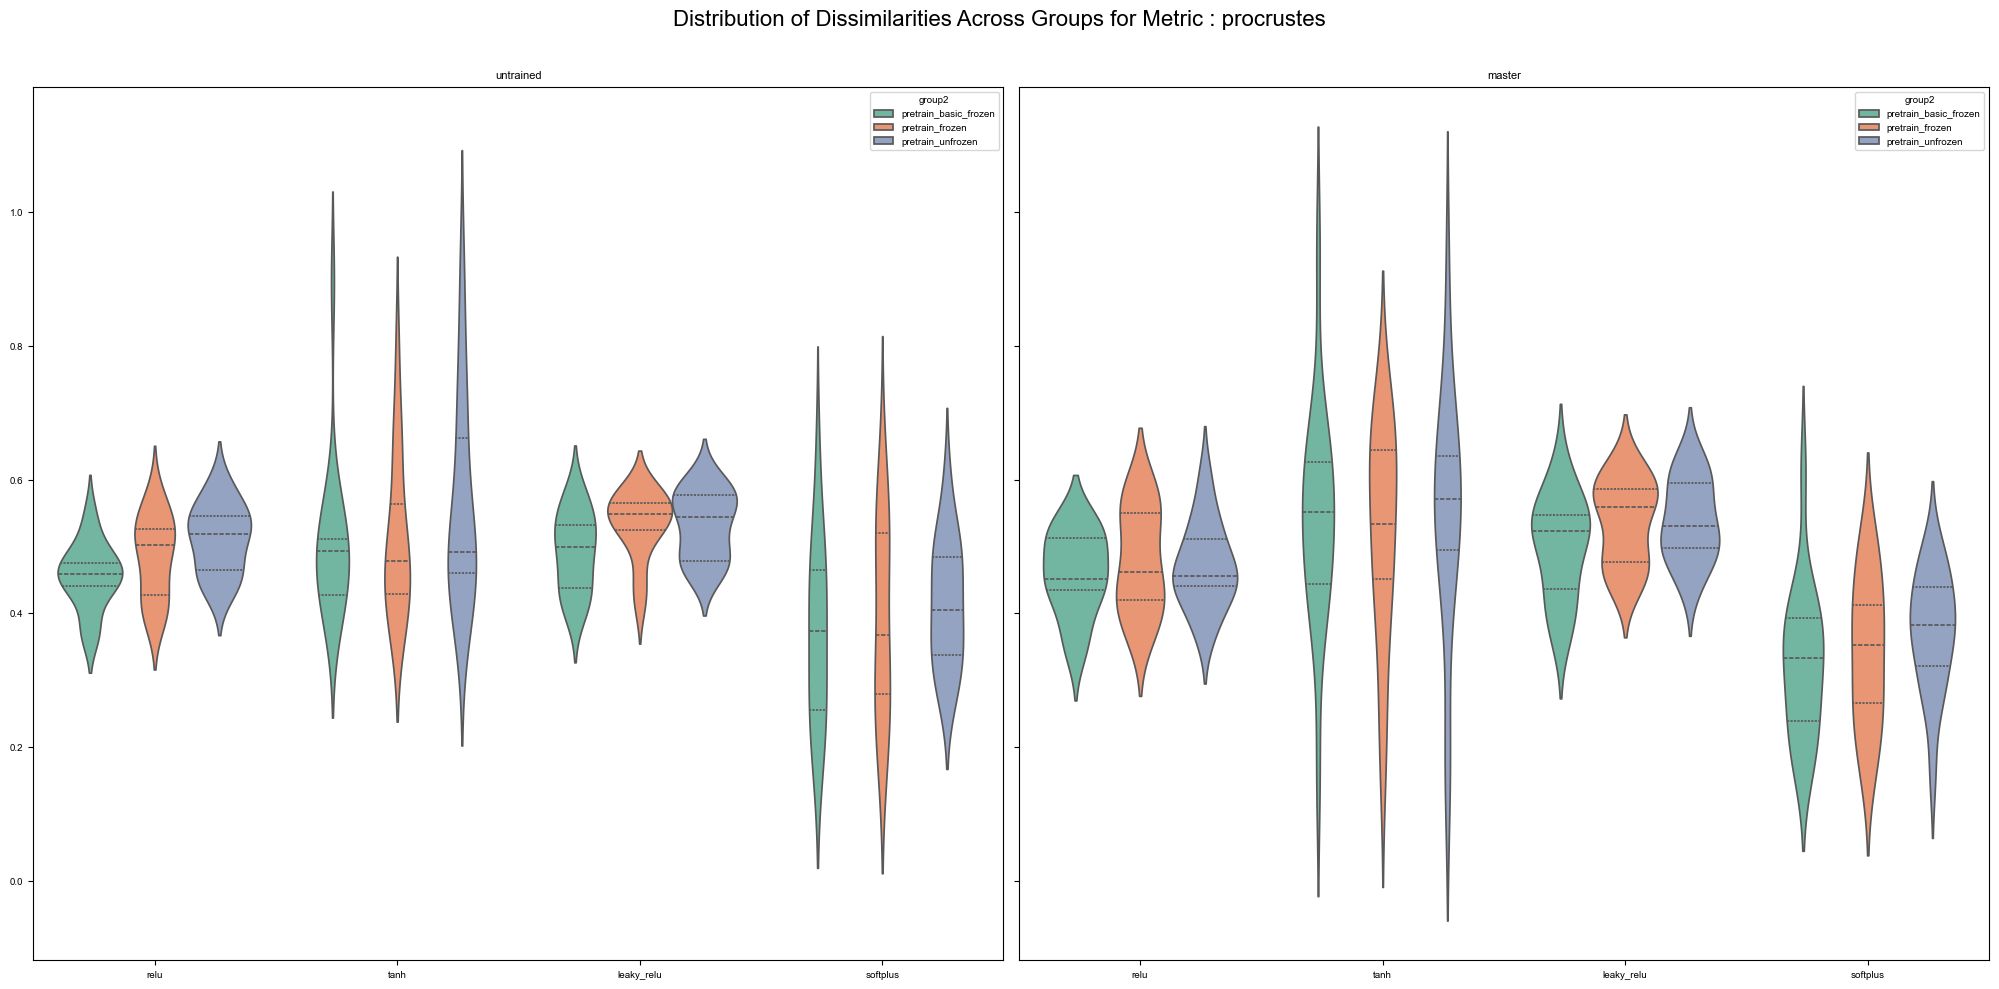

In [6]:

discriminate_df(df_selected, groups_base, criteria="activation")

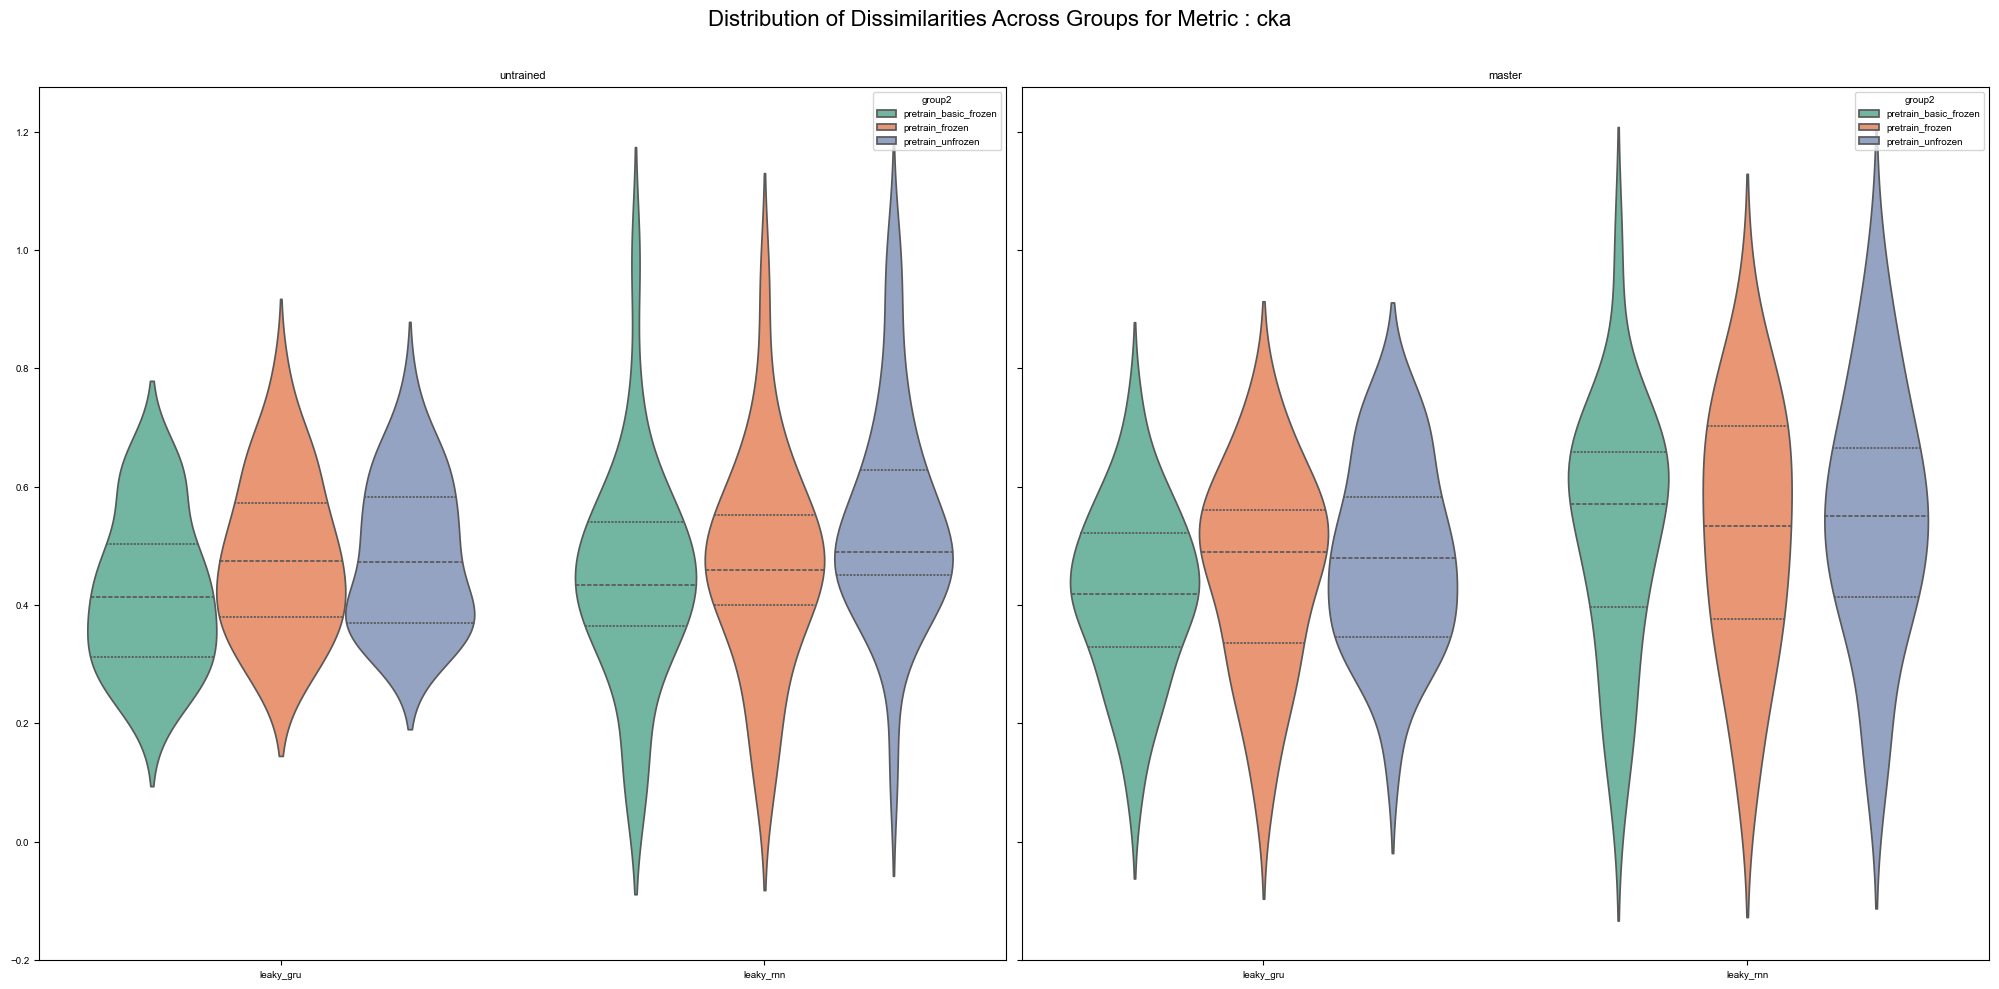

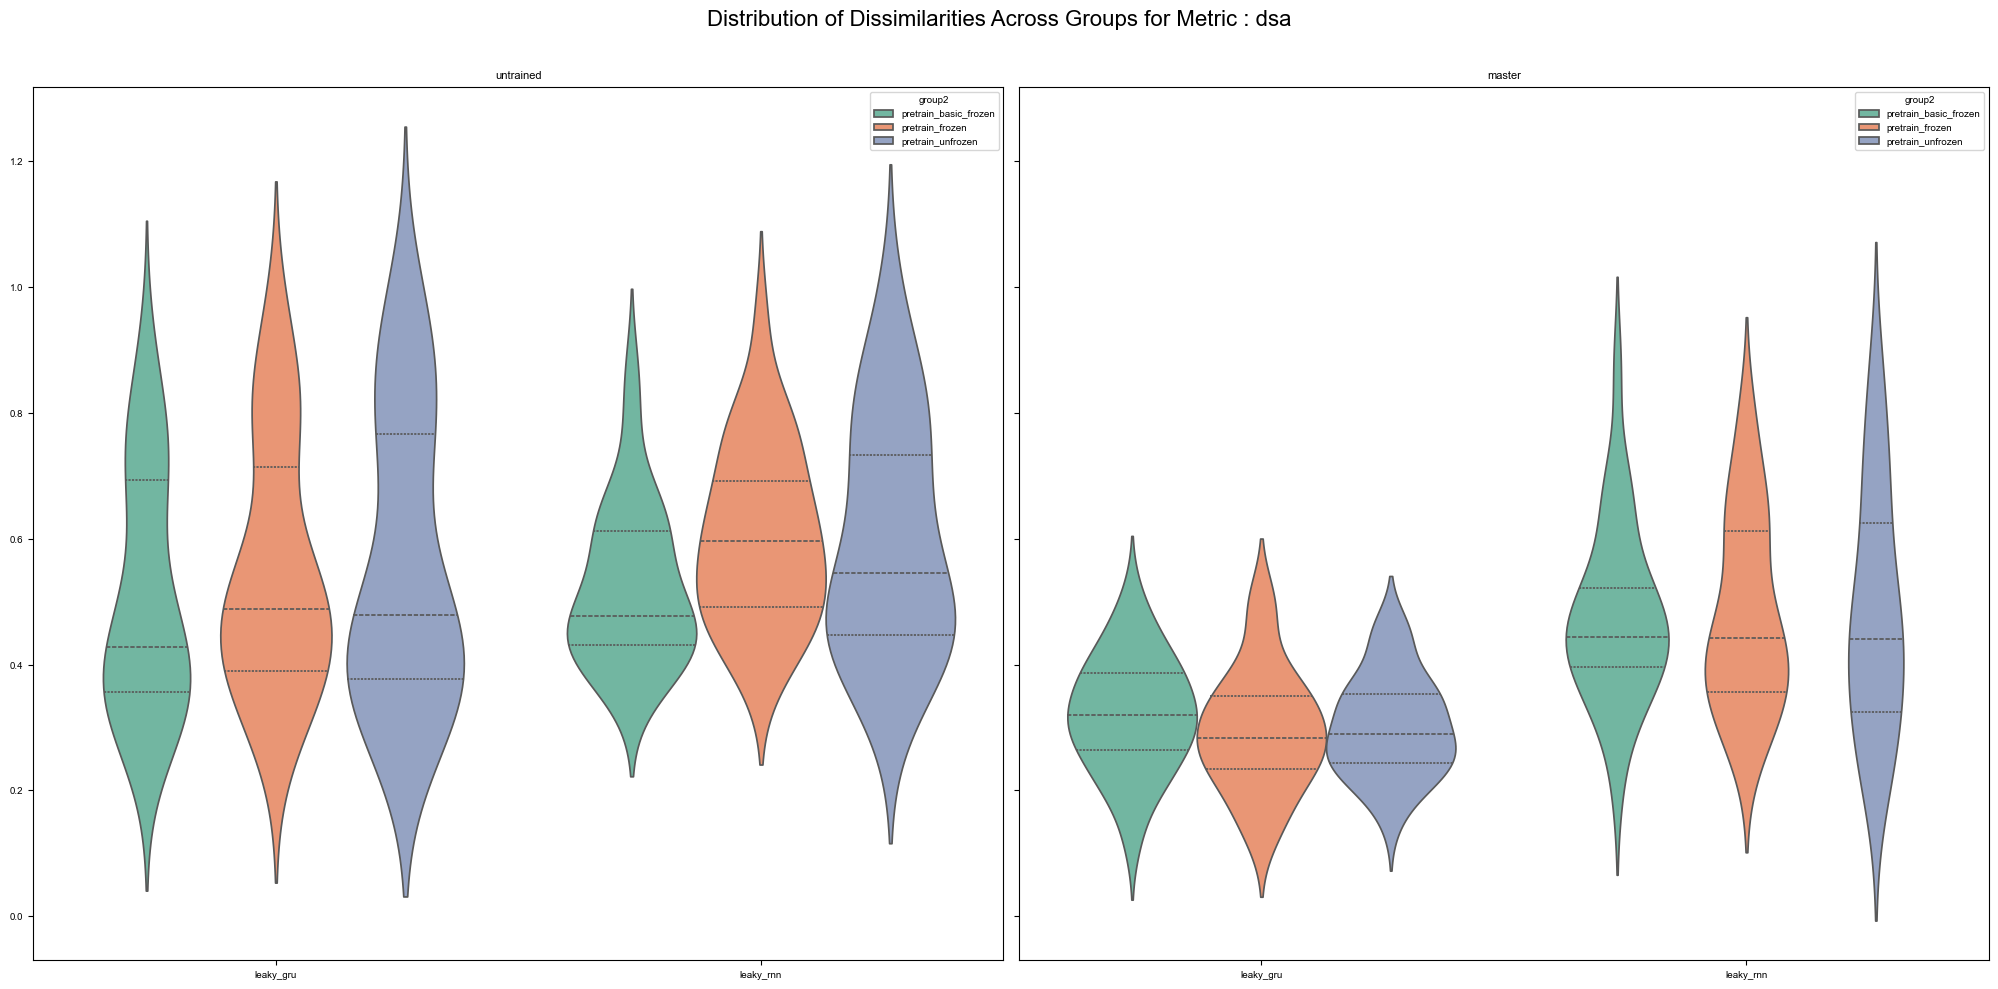

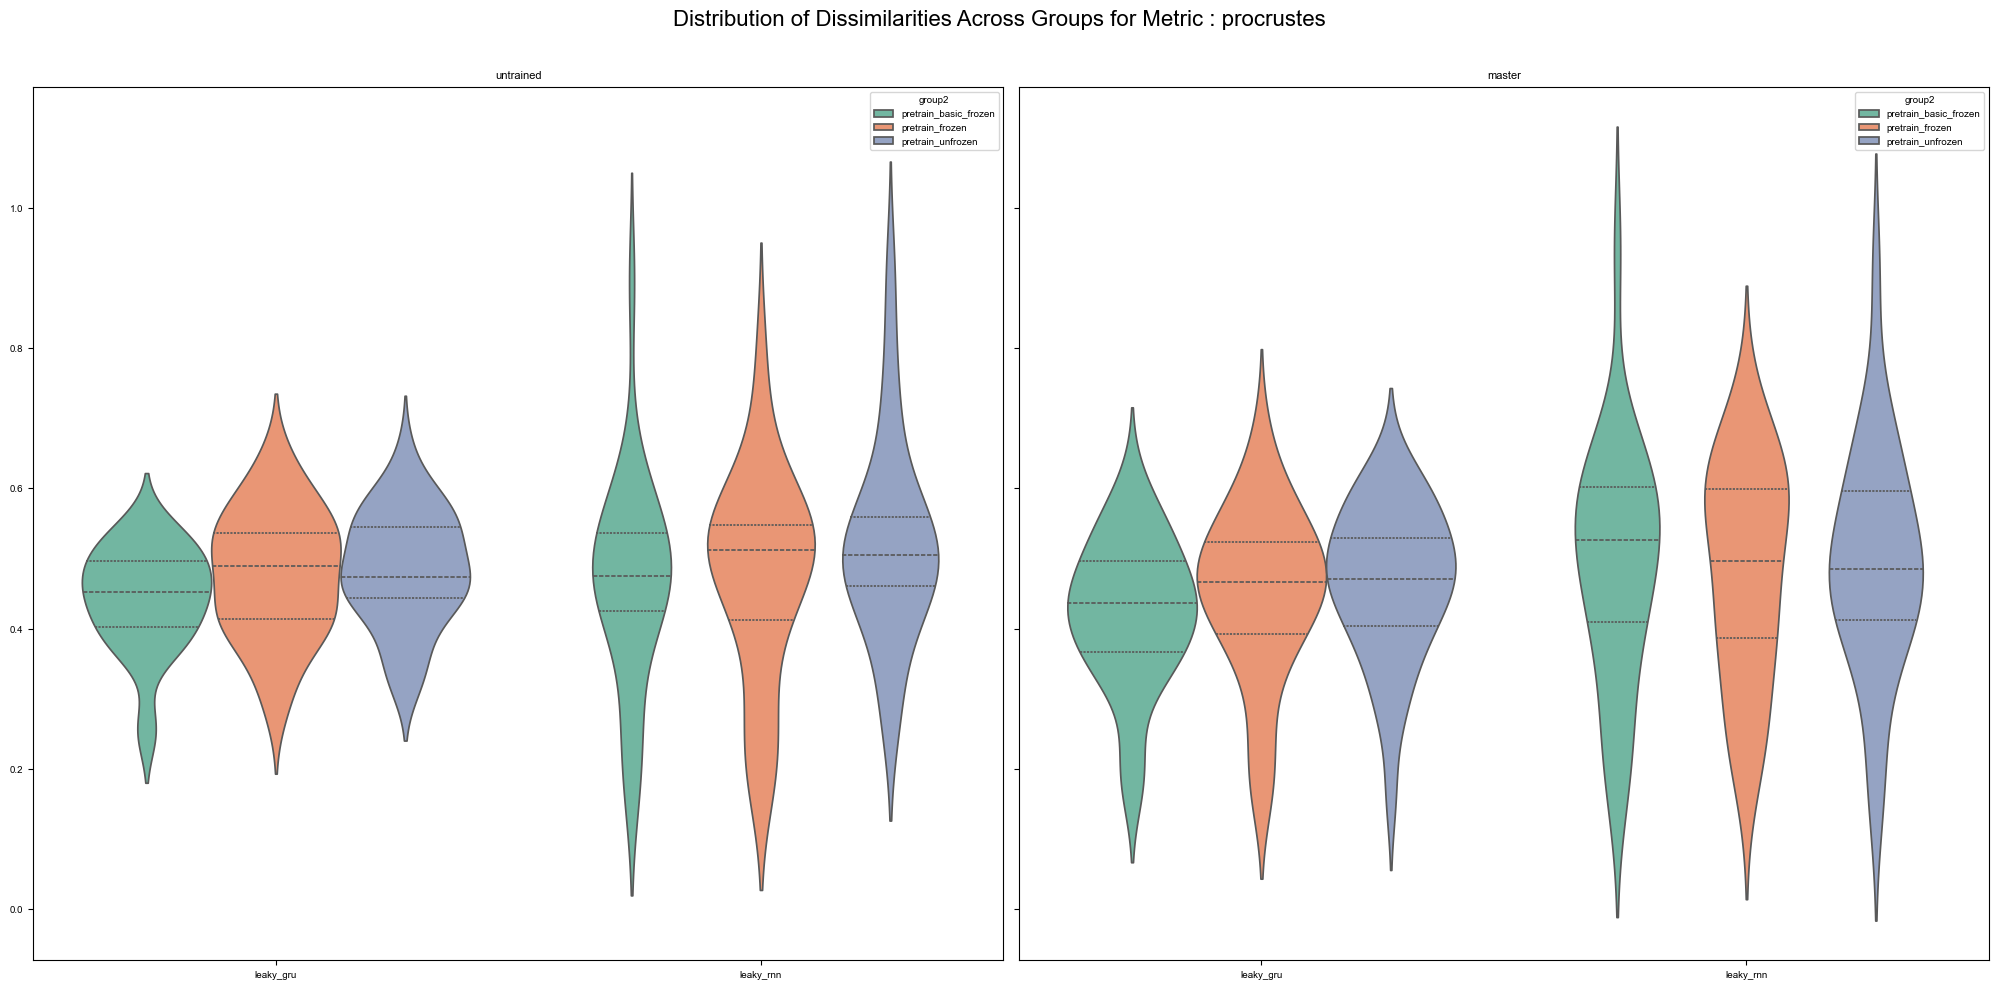

In [7]:
discriminate_df(df_selected, groups_base, criteria="model_type")

In [8]:
groups_trained = [
    "master",
    "pretrain_frozen",
    "pretrain_unfrozen",
]
other_groups = [group for group in df["group1"].unique() if group not in groups_trained]

In [9]:
df_selected = df[
    # For rows where model1 is in group1
    ((df["group1"].isin(groups_trained)) & (df["accuracy_1"] == 1))
    |
    # For rows where model1 is not in group1 (accuracy_1 can be anything)
    (~df["group1"].isin(groups_trained))
    |
    # For rows where model2 is in group2
    ((df["group2"].isin(groups_trained)) & (df["accuracy_2"] == 1))
    |
    # For rows where model2 is not in group2 (accuracy_2 can be anything)
    (~df["group2"].isin(groups_trained))
]

In [10]:
models_trained_per_group = {group+"_master": [] for group in groups_trained}
for group in groups_trained:
    df_selected_group = df_selected[
        (df_selected["group1"] == group) | (df_selected["group2"] == group)
    ]
    for row, data in df_selected_group.iterrows():
        model = data["model_type"]+"_"+data["activation"]+"_"+ str(data["hidden_size"])+"_"+str(data["lr"])+"_"+str(data["batch_size"])
        models_trained_per_group[group + "_master"].append(model)



In [11]:
models_trained_per_group

{'master_master': ['leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_gru_relu_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0.01_64',
  'leaky_rnn_tanh_128_0

In [12]:
for group in models_trained_per_group:
    models_trained_per_group[group] = list(set(models_trained_per_group[group]))

In [13]:
len(models_trained_per_group["master_master"])

56

In [14]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

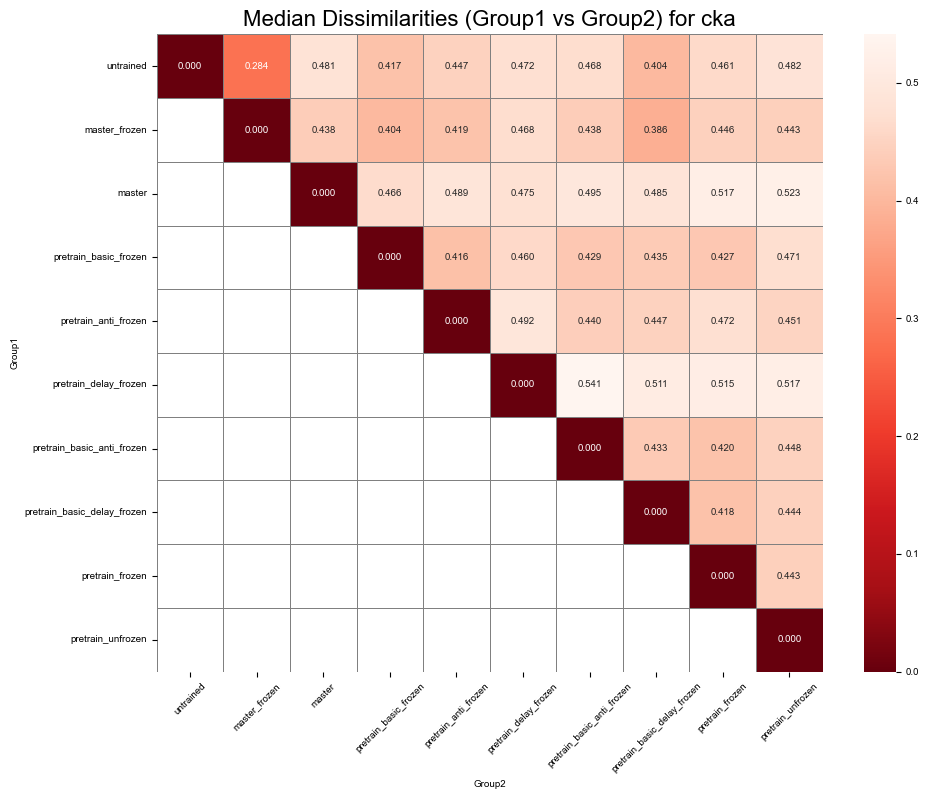

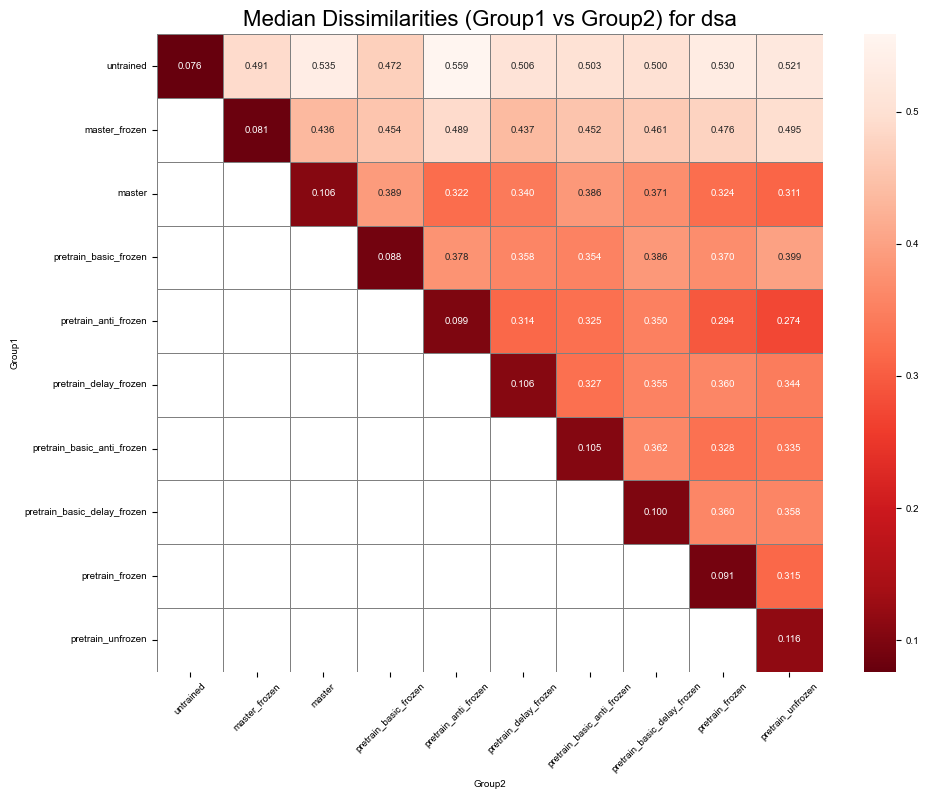

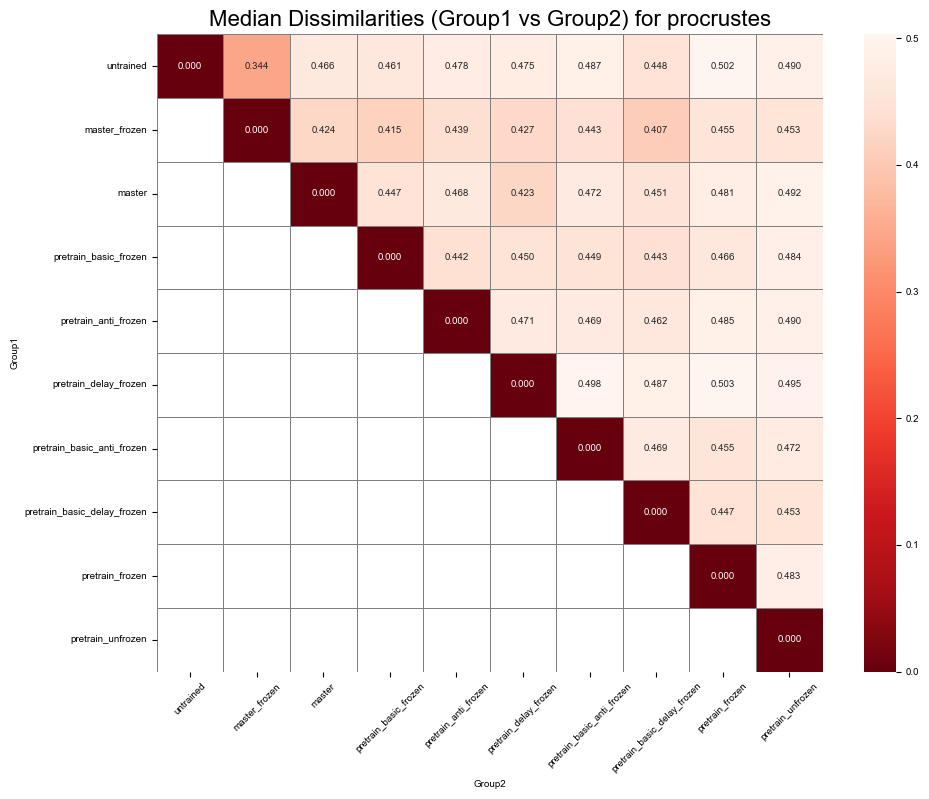

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    #TODO : same scale for all metrics : Same min max for all metrics
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


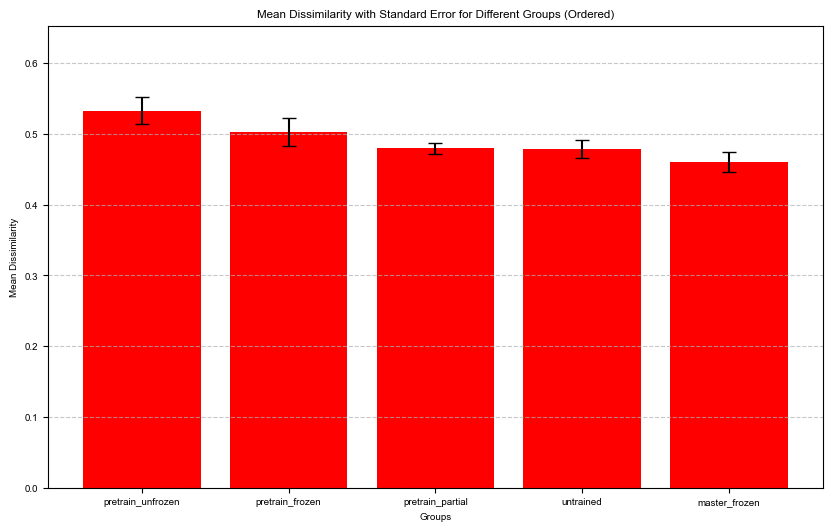

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


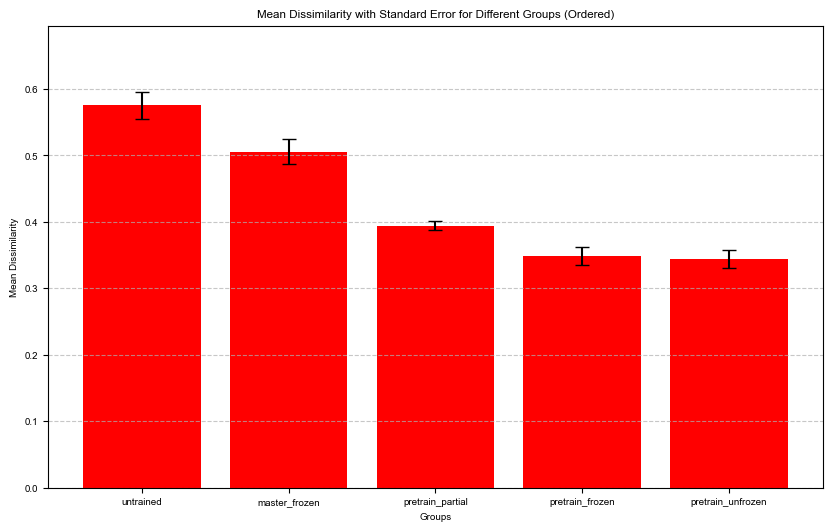

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


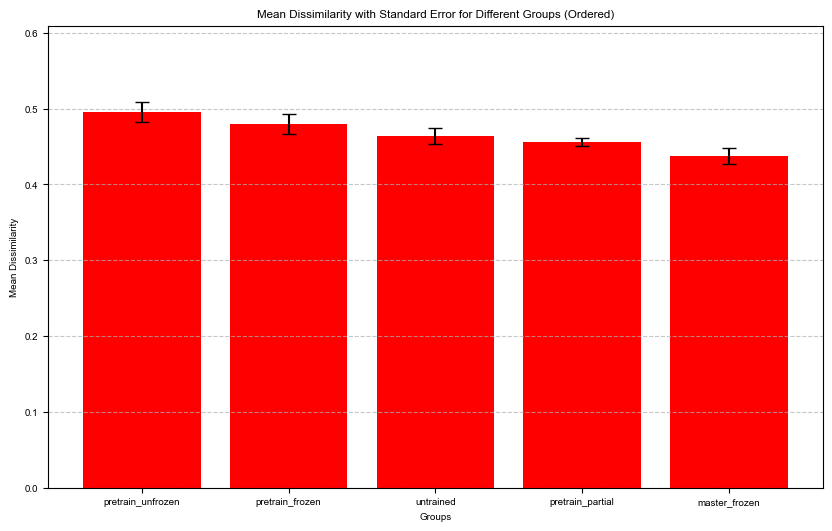

In [16]:
from numpy import mean


for measure in measures:
    # Create a bar chart with error bars
    df_standard = t_standart_error_dissimilarity_all_groups(df_selected, measure)
    groups, mean_dissimilarities, standard_errors = (
        df_standard["group"],
        df_standard["mean_dissimilarities"],
        df_standard["standard_errors"],
    )
    # Step 1: Zip the data together and sort by mean_dissimilarities in descending order
    sorted_data = sorted(zip(mean_dissimilarities, standard_errors, groups), reverse=True)

    # Step 2: Unzip the sorted data back into separate lists
    mean_dissimilarities, standard_errors, groups = zip(*sorted_data)

    # Step 3: Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(groups, mean_dissimilarities, yerr=standard_errors, capsize=5, color="red")
    plt.xlabel("Groups")
    plt.ylabel("Mean Dissimilarity")
    plt.title("Mean Dissimilarity with Standard Error for Different Groups (Ordered)")
    plt.ylim(
        0, max(mean_dissimilarities) + max(standard_errors) + 0.1
    )  # Adjust the y-axis limit if needed
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    # Display the plot
    plt.show()

In [17]:
df_test = t_test_all_pairs(df_selected, "dsa")

['untrained' 'master_frozen' 'master' 'pretrain_partial' 'pretrain_frozen'
 'pretrain_unfrozen']


In [18]:
df_test

pairs       p_value  adjusted_p_value
0              (untrained, master_frozen)  1.180854e-02      1.312060e-02
1           (untrained, pretrain_partial)  7.044456e-24      7.044456e-23
2            (untrained, pretrain_frozen)  4.623202e-16      1.541067e-15
3          (untrained, pretrain_unfrozen)  2.807244e-16      1.403622e-15
4              (master_frozen, untrained)  1.180854e-02      1.312060e-02
5       (master_frozen, pretrain_partial)  1.063719e-10      2.659298e-10
6        (master_frozen, pretrain_frozen)  9.095262e-10      1.515877e-09
7      (master_frozen, pretrain_unfrozen)  4.521407e-10      9.042814e-10
8           (pretrain_partial, untrained)  7.044456e-24      7.044456e-23
9       (pretrain_partial, master_frozen)  1.063719e-10      2.659298e-10
10    (pretrain_partial, pretrain_frozen)  9.444267e-03      1.180533e-02
11  (pretrain_partial, pretrain_unfrozen)  4.942379e-03      7.060541e-03
12           (pretrain_frozen, untrained)  4.623202e-16      1.541067e-15
13       (pretrain_frozen, master_frozen)  9.095262e-10      1.515877e-09
14    (pretrain_frozen, pretrain_partial)  9.444267e-03      1.180533e-02
15   (pretrain_frozen, pretrain_unfrozen)  8.156104e-01      8.156104e-01
16         (pretrain_unfrozen, untrained)  2.807244e-16      1.403622e-15
17     (pretrain_unfrozen, master_frozen)  4.521407e-10      9.042814e-10
18  (pretrain_unfrozen, pretrain_partial)  4.942379e-03      7.060541e-03
19   (pretrain_unfrozen, pretrain_frozen)  8.156104e-01      8.156104e-01

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_4915/1636102228.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette="Reds")


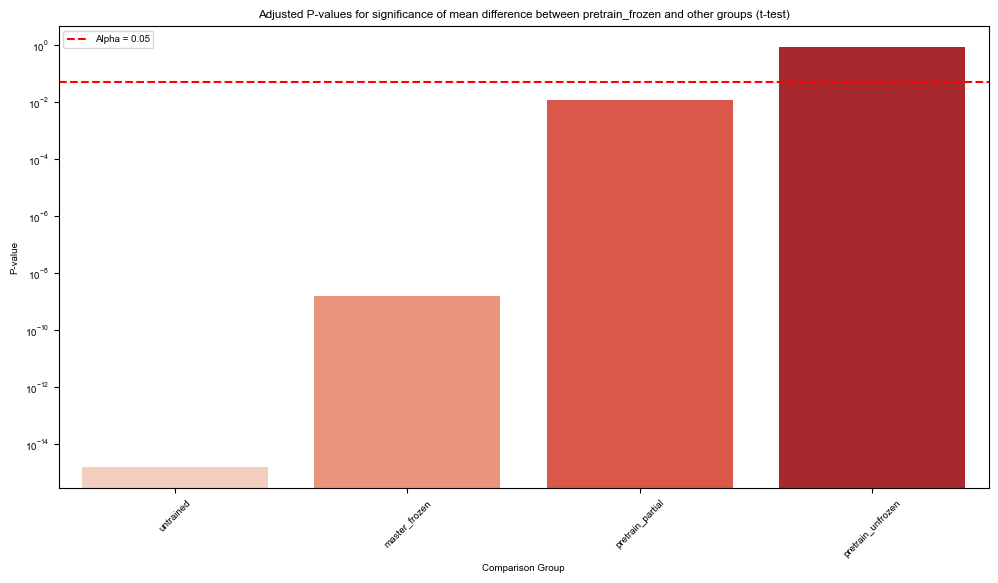

In [19]:
# Extract relevant comparisons where pretrain_frozen is involved
pretrain_frozen_comparisons = df_test[df_test["pairs"].apply(lambda x: "pretrain_frozen" in x)]

# Create a dataframe for the bar plots
bar_data = pretrain_frozen_comparisons.copy()
bar_data["comparison"] = bar_data["pairs"].apply(
    lambda x: x[0] if x[1] == "pretrain_frozen" else x[1]
)

# Bar plot for p-values where pretrain_frozen is one of the groups
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette="Reds")
plt.yscale("log")  # Use log scale for better visibility of p-values
plt.axhline(y=0.05, color="red", linestyle="--", label="Alpha = 0.05")
plt.title("Adjusted P-values for significance of mean difference between pretrain_frozen and other groups (t-test)")
plt.xlabel("Comparison Group")
plt.ylabel("P-value")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
df

model_type activation  hidden_size     lr  batch_size  \
0      leaky_gru       relu          128  0.010          64   
1      leaky_gru       relu          128  0.010          64   
2      leaky_gru       relu          128  0.010          64   
3      leaky_gru       relu          128  0.010          64   
4      leaky_gru       relu          128  0.010          64   
...          ...        ...          ...    ...         ...   
16795  leaky_rnn       tanh          256  0.001         128   
16796  leaky_rnn       tanh          256  0.001         128   
16797  leaky_rnn       tanh          256  0.001         128   
16798  leaky_rnn       tanh          256  0.001         128   
16799  leaky_rnn       tanh          256  0.001         128   

                  group1                       group2     measure  \
0              untrained                    untrained         cka   
1              untrained                master_frozen         cka   
2              untrained                       master         cka   
3              untrained        pretrain_basic_frozen         cka   
4              untrained         pretrain_anti_frozen         cka   
...                  ...                          ...         ...   
16795  pretrain_unfrozen        pretrain_delay_frozen  procrustes   
16796  pretrain_unfrozen   pretrain_basic_anti_frozen  procrustes   
16797  pretrain_unfrozen  pretrain_basic_delay_frozen  procrustes   
16798  pretrain_unfrozen              pretrain_frozen  procrustes   
16799  pretrain_unfrozen            pretrain_unfrozen  procrustes   

       dissimilarity  accuracy_1  accuracy_2  
0       0.000000e+00        -1.0   -1.000000  
1       2.831666e-01        -1.0    0.900244  
2       4.131438e-01        -1.0    1.000000  
3       4.158599e-01        -1.0    1.000000  
4       2.954913e-01        -1.0   -1.000000  
...              ...         ...         ...  
16795   6.247184e-01         1.0    1.000000  
16796   7.561041e-01         1.0    0.954836  
16797   6.349755e-01         1.0    0.499545  
16798   6.490532e-01         1.0    0.551069  
16799   5.612214e-08         1.0    1.000000  

[16800 rows x 11 columns]

In [21]:
group_pairs = find_group_pairs(config, taskset)
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df_selected)

0.0005475982738490925
0.00035485795295919775
5.197069373252816e-05
0.0
0.0
0.0
0.0
0.0
0.00010691271365803612
0.00014668904419412598
0.0
0.0
0.00044801524417248384
0.0
0.0
0.00040530334870414464
6.146928187067413e-05
0.0
0.0003859928799888612
0.0
0.0003903104975588878
0.00011178731323380209
0.0
0.0
0.0
0.0004367757063754585
0.00037974931200068784
0.0001003709707401157
0.0
0.00040277951722467176
0.0005413532253184528
0.0
0.0
0.00046692018937444235
0.0006882213463479392
0.09464098513126373
0.11544372886419296
0.04476877301931381
0.11859819293022156
0.05966814607381821
0.1290706992149353
0.15713702142238617
0.17750458419322968
0.08415882289409637
0.02094816230237484
0.07625135779380798
0.06043881177902222
0.08828947693109512
0.10150566697120667
0.06519297510385513
0.17982150614261627
0.16015569865703583
0.02211371622979641
0.14498156309127808
0.15445615351200104
0.0843026414513588
0.16727063059806824
0.13710615038871765
0.10648609697818756
0.05433332175016403
0.15054145455360413
0.1120657

In [22]:
dissimilarities_per_shared_task

{'dsa': {100: {'leaky_gru_relu_128_0.01_64': [0.10472925007343292],
   'leaky_gru_leaky_relu_128_0.001_128': [0.07412803173065186],
   'leaky_gru_leaky_relu_128_0.01_128': [0.07344076037406921],
   'leaky_rnn_leaky_relu_256_0.001_128': [0.026111235842108727],
   'leaky_rnn_tanh_128_0.001_64': [0.07490941882133484],
   'leaky_rnn_leaky_relu_128_0.001_64': [0.2126605212688446],
   'leaky_gru_relu_256_0.01_64': [0.024519432336091995],
   'leaky_gru_tanh_256_0.01_128': [0.05216865986585617],
   'leaky_gru_relu_128_0.001_64': [0.06722896546125412],
   'leaky_gru_relu_128_0.01_128': [0.027995232492685318],
   'leaky_gru_tanh_256_0.001_64': [0.14225883781909943],
   'leaky_gru_softplus_256_0.001_64': [0.03736606240272522],
   'leaky_rnn_relu_256_0.001_64': [0.026924997568130493],
   'leaky_rnn_leaky_relu_128_0.001_128': [0.08404387533664703],
   'leaky_gru_leaky_relu_128_0.001_64': [0.02300161123275757],
   'leaky_gru_leaky_relu_256_0.001_128': [0.022522367537021637],
   'leaky_rnn_tanh_128_0

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [23]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset, models_trained_per_group)

leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_64
leaky_gru_leaky_relu_256_0.01_64
leaky_rnn_relu_256_0.01_128
leaky_rnn_leaky_relu_256_0.01_128
leaky_gru_leaky_relu_128_0.01_64
leaky_rnn_relu_128_0.01_128
leaky_rnn_leaky_relu_128_0.01_128
leaky_rnn_relu_128_0.01_64
leaky_rnn_relu_256_0.01_

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_rnn.py:455: RuntimeWarning: Mean of empty slice
  np.nanmean(dissimilarities_interpolated[measure][group]),
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


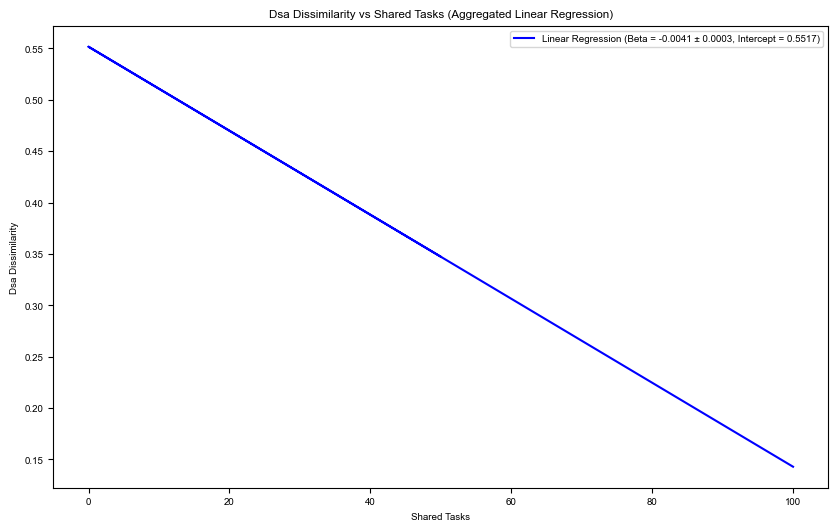

For dsa:
  Slope (Beta) = -0.0041
  Standard Error of Beta = 0.0003
  Intercept = 0.5517
  Mis-specification Error (MSE) = 0.0205



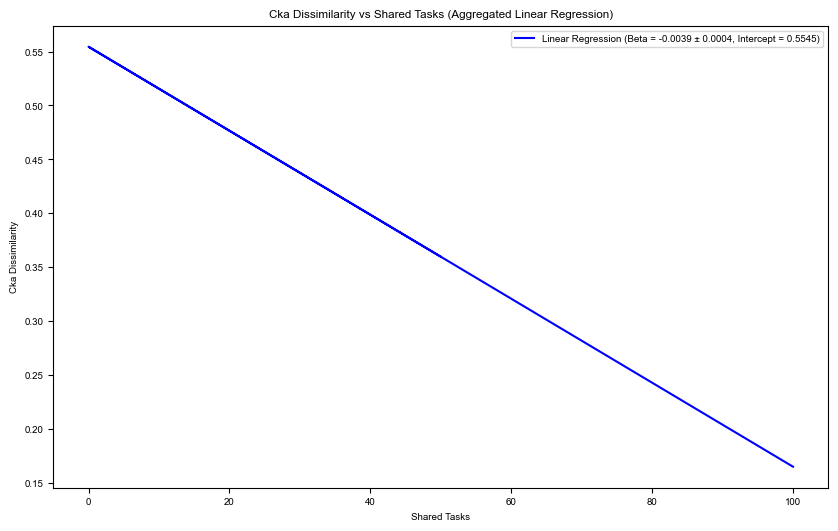

For cka:
  Slope (Beta) = -0.0039
  Standard Error of Beta = 0.0004
  Intercept = 0.5545
  Mis-specification Error (MSE) = 0.0447



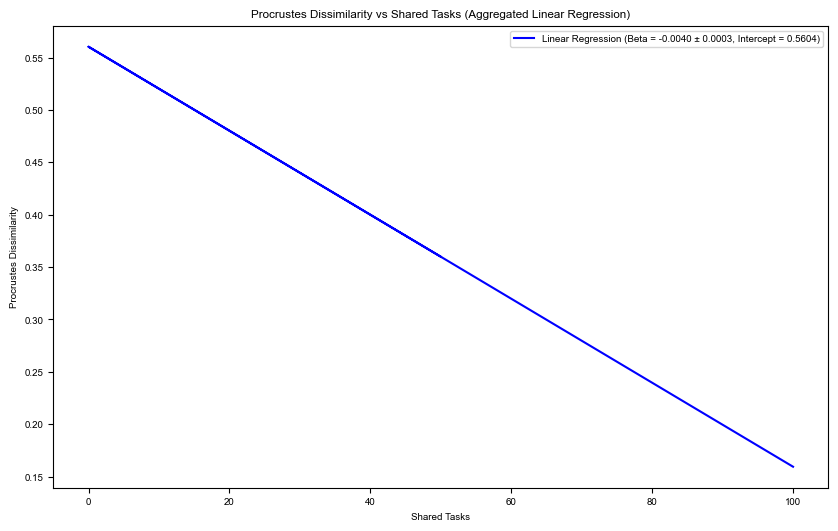

For procrustes:
  Slope (Beta) = -0.0040
  Standard Error of Beta = 0.0003
  Intercept = 0.5604
  Mis-specification Error (MSE) = 0.0307



In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example dictionary for dissimilarities_per_shared_task
# Assuming it's structured like:
# dissimilarities_per_shared_task = {
#     'measure1': {
#         10: {'model1': [0.1], 'model2': [0.2]},
#         20: {'model1': [0.3], 'model2': [0.35]},
#         ...
#     },
#     'measure2': { ... },
#     'measure3': { ... }
# }

# Iterate over each measure to compute linear regression and uncertainty
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y

    # Aggregate all (shared_task, dissimilarity) pairs across all models
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[
                0
            ]  # Extract the single dissimilarity value for the current model
            X.append(shared_tasks)
            y.append(dissimilarity)

    # Convert to numpy arrays for linear regression
    X = np.array(X).reshape(-1, 1)  # Reshape to a 2D array
    y = np.array(y)

    # Perform linear regression using least squares estimator
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Predict y values for the regression line
    y_pred = model.predict(X)

    # Compute residuals and their variance
    residuals = y - y_pred
    residual_variance = np.var(
        residuals, ddof=2
    )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # Mis-specification error (Mean Squared Error)
    mse = np.mean(residuals**2)

    # Plot only the regression line
    plt.figure(figsize=(10, 6))
    plt.plot(
        X,
        y_pred,
        "-",
        color="blue",
        label=f"Linear Regression (Beta = {beta:.4f} ± {standard_error_beta:.4f}, Intercept = {intercept:.4f})",
    )
    plt.xlabel("Shared Tasks")
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(
        f"{measure.capitalize()} Dissimilarity vs Shared Tasks (Aggregated Linear Regression)"
    )
    plt.legend()
    plt.show()

    # Print the regression results
    print(f"For {measure}:")
    print(f"  Slope (Beta) = {beta:.4f}")
    print(f"  Standard Error of Beta = {standard_error_beta:.4f}")
    print(f"  Intercept = {intercept:.4f}")
    print(f"  Mis-specification Error (MSE) = {mse:.4f}\n")

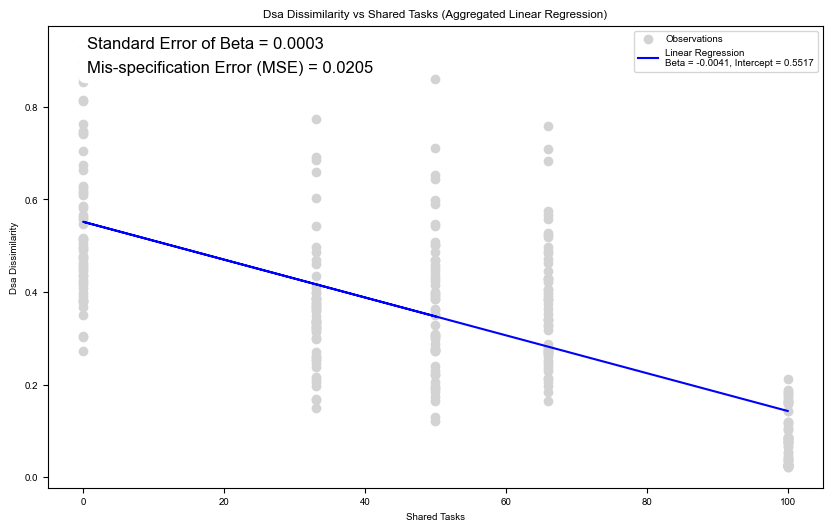

For dsa:
  Slope (Beta) = -0.0041
  Standard Error of Beta = 0.0003
  Intercept = 0.5517
  Mis-specification Error (MSE) = 0.0205



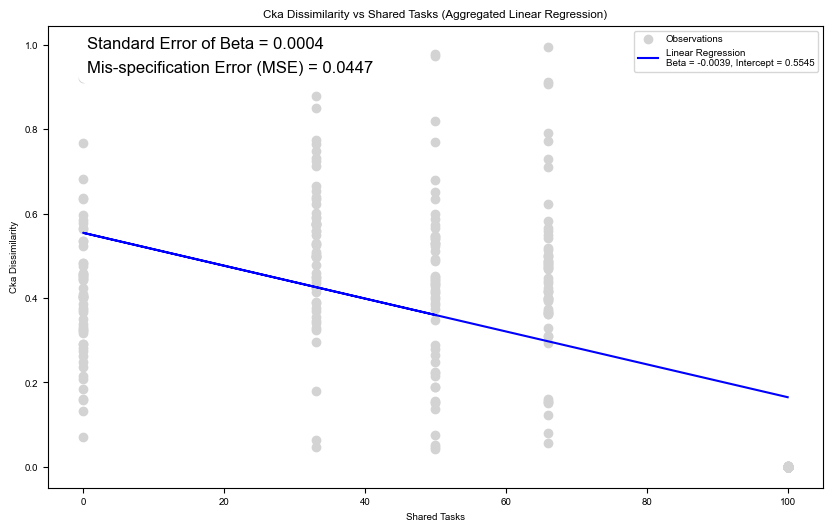

For cka:
  Slope (Beta) = -0.0039
  Standard Error of Beta = 0.0004
  Intercept = 0.5545
  Mis-specification Error (MSE) = 0.0447



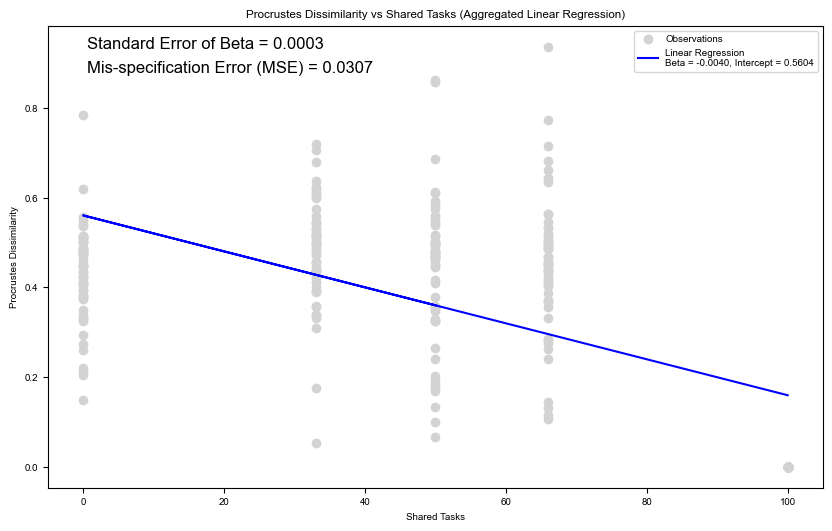

For procrustes:
  Slope (Beta) = -0.0040
  Standard Error of Beta = 0.0003
  Intercept = 0.5604
  Mis-specification Error (MSE) = 0.0307



In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example dictionary for dissimilarities_per_shared_task
# Assuming it's structured like:
# dissimilarities_per_shared_task = {
#     'measure1': {
#         10: {'model1': [0.1], 'model2': [0.2]},
#         20: {'model1': [0.3], 'model2': [0.35]},
#         ...
#     },
#     'measure2': { ... },
#     'measure3': { ... }
# }

# Iterate over each measure to compute linear regression and uncertainty
for measure in dissimilarities_per_shared_task:
    X = []  # Store shared_tasks as X
    y = []  # Store dissimilarities as y

    # Aggregate all (shared_task, dissimilarity) pairs across all models
    for shared_tasks, models_data in dissimilarities_per_shared_task[measure].items():
        for model, dissimilarity_list in models_data.items():
            dissimilarity = dissimilarity_list[
                0
            ]  # Extract the single dissimilarity value for the current model
            X.append(shared_tasks)
            y.append(dissimilarity)

    # Convert to numpy arrays for linear regression
    X = np.array(X).reshape(-1, 1)  # Reshape to a 2D array
    y = np.array(y)

    # Perform linear regression using least squares estimator
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (beta) and intercept
    beta = model.coef_[0]
    intercept = model.intercept_

    # Predict y values for the regression line
    y_pred = model.predict(X)

    # Compute residuals and their variance
    residuals = y - y_pred
    residual_variance = np.var(
        residuals, ddof=2
    )  # ddof=2 because we have 2 parameters estimated (slope and intercept)

    # Compute variance of X
    X_mean = np.mean(X)
    X_variance = np.sum((X - X_mean) ** 2)

    # Standard error of the slope (beta)
    standard_error_beta = np.sqrt(residual_variance / X_variance)

    # Mis-specification error (Mean Squared Error)
    mse = np.mean(residuals**2)

    # Plot all observations and the regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="lightgray", label="Observations")
    plt.plot(
        X,
        y_pred,
        "-",
        color="blue",
        label=f"Linear Regression\nBeta = {beta:.4f}, Intercept = {intercept:.4f}",
    )

    # Annotate the plot with Standard Error of Beta and Mis-specification Error
    plt.annotate(
        f"Standard Error of Beta = {standard_error_beta:.4f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )
    plt.annotate(
        f"Mis-specification Error (MSE) = {mse:.4f}",
        xy=(0.05, 0.90),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"),
    )

    plt.xlabel("Shared Tasks")
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(
        f"{measure.capitalize()} Dissimilarity vs Shared Tasks (Aggregated Linear Regression)"
    )
    plt.legend()
    plt.show()

    # Print the regression results
    print(f"For {measure}:")
    print(f"  Slope (Beta) = {beta:.4f}")
    print(f"  Standard Error of Beta = {standard_error_beta:.4f}")
    print(f"  Intercept = {intercept:.4f}")
    print(f"  Mis-specification Error (MSE) = {mse:.4f}\n")

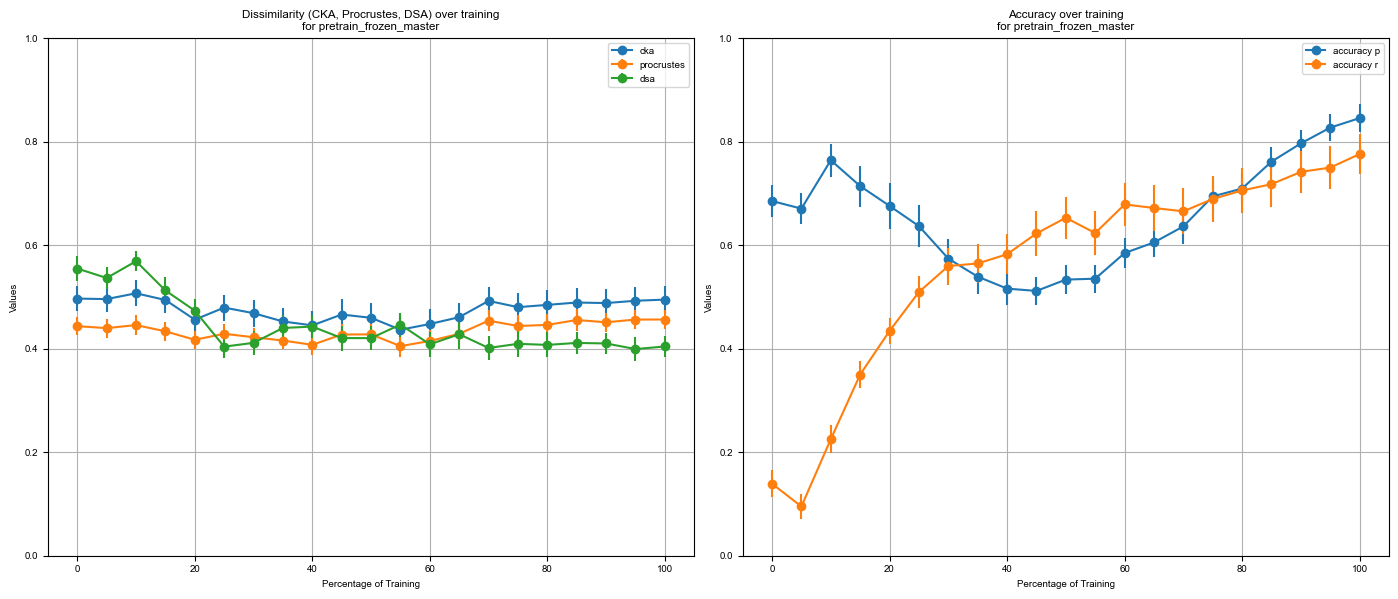

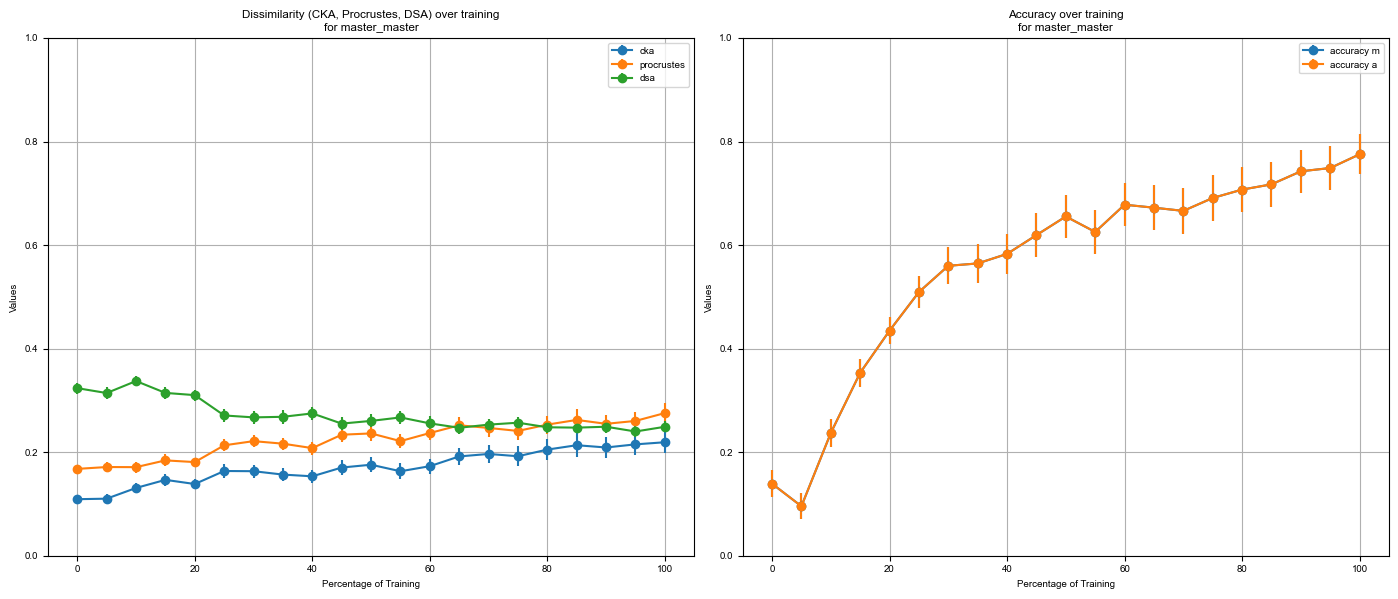

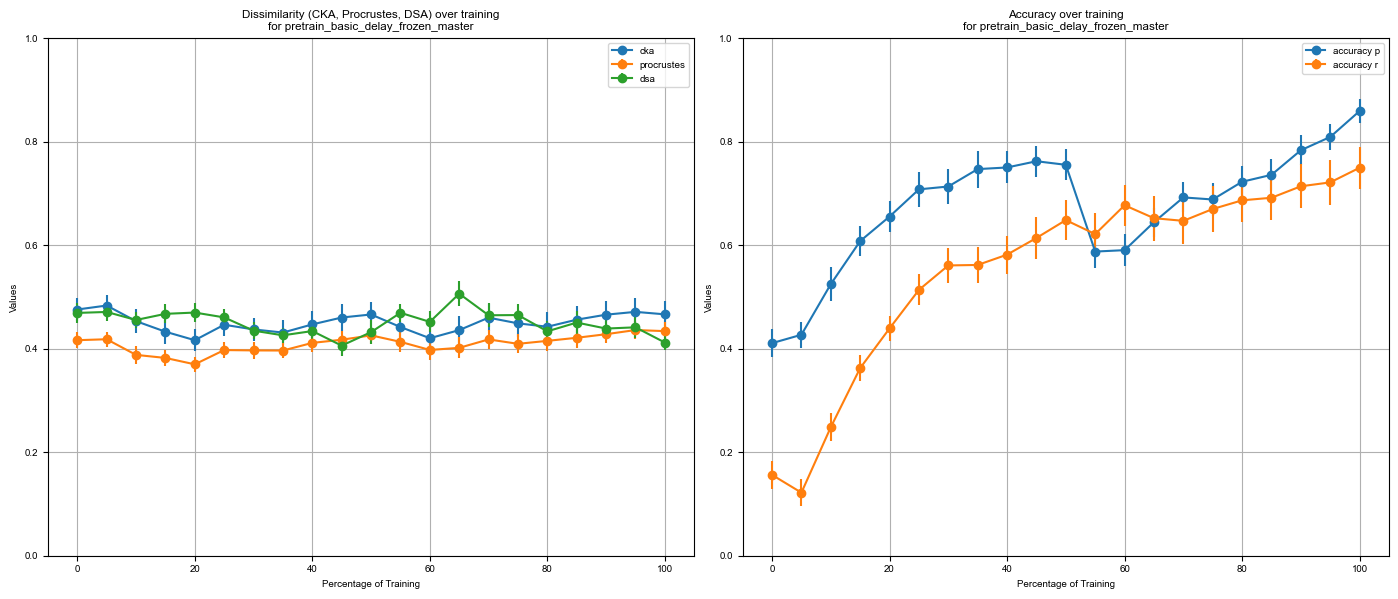

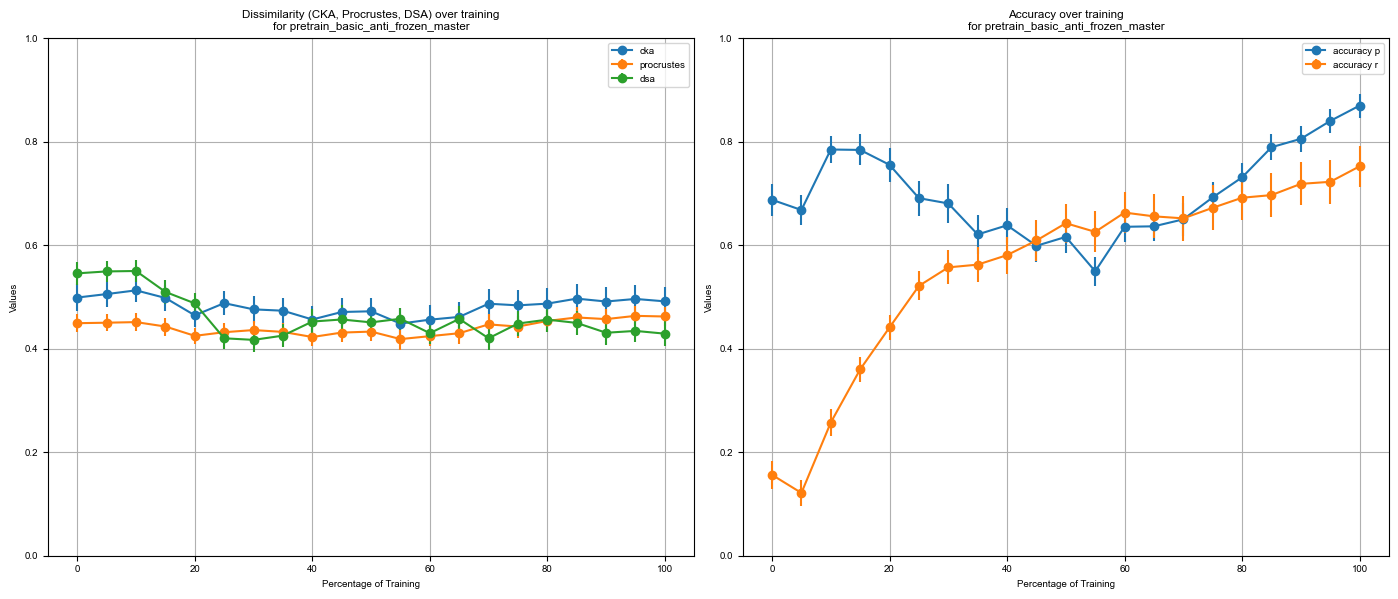

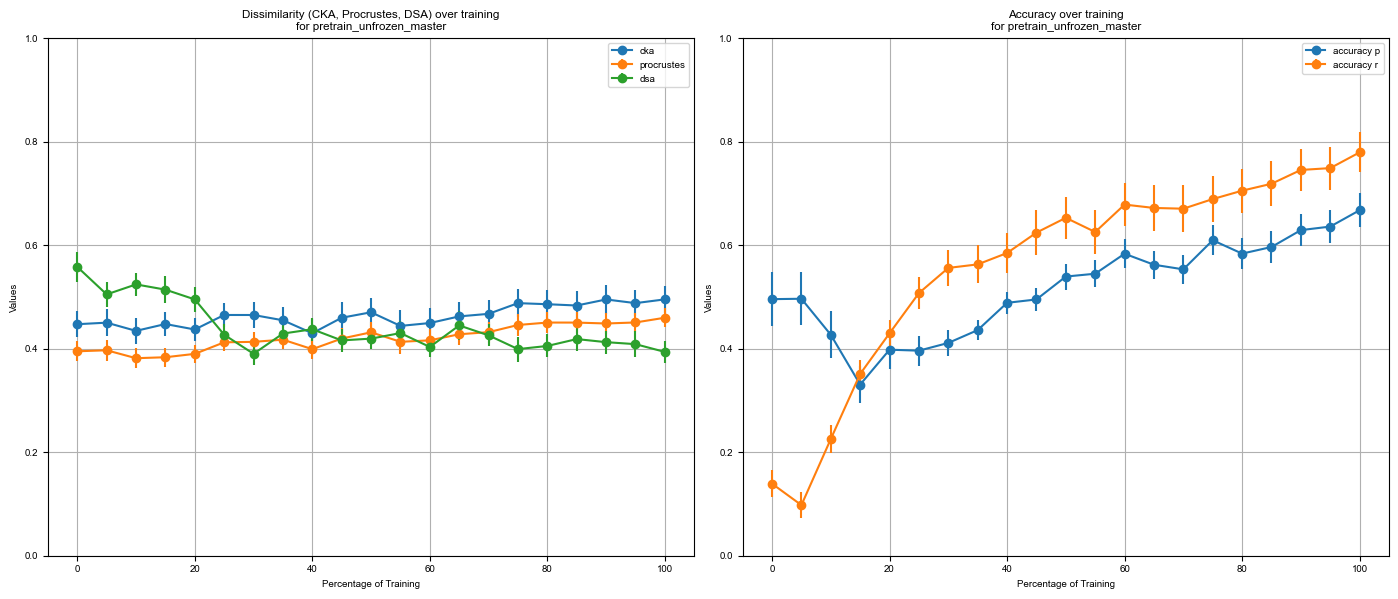

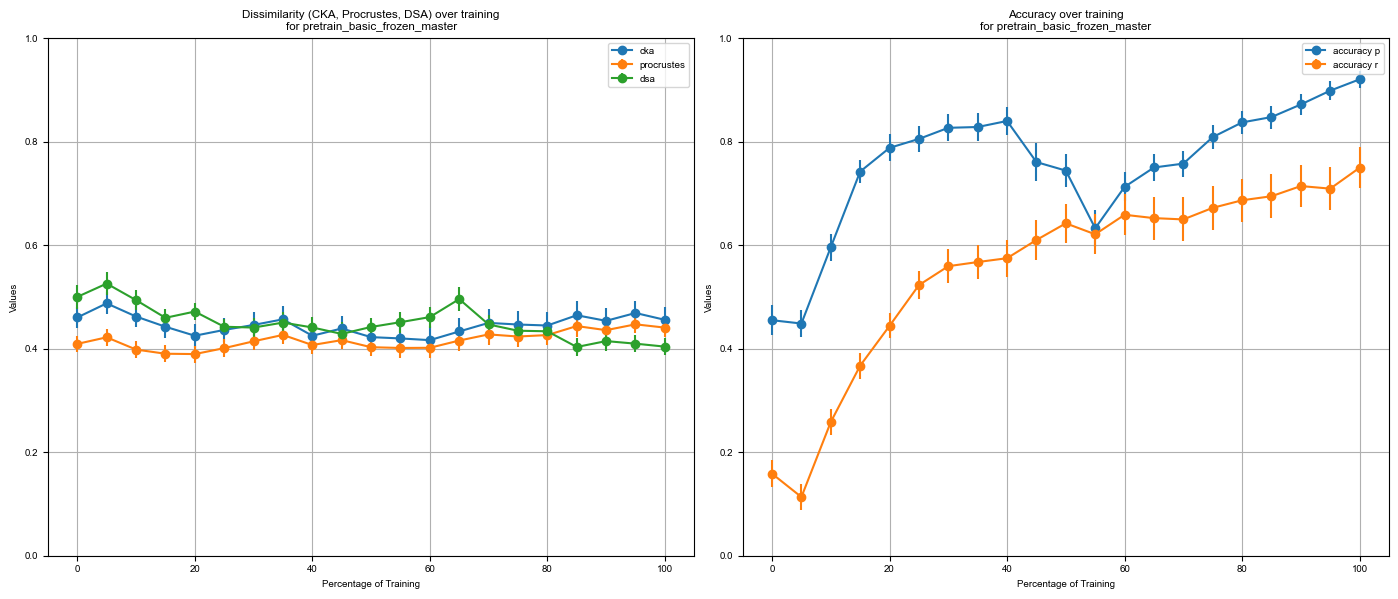

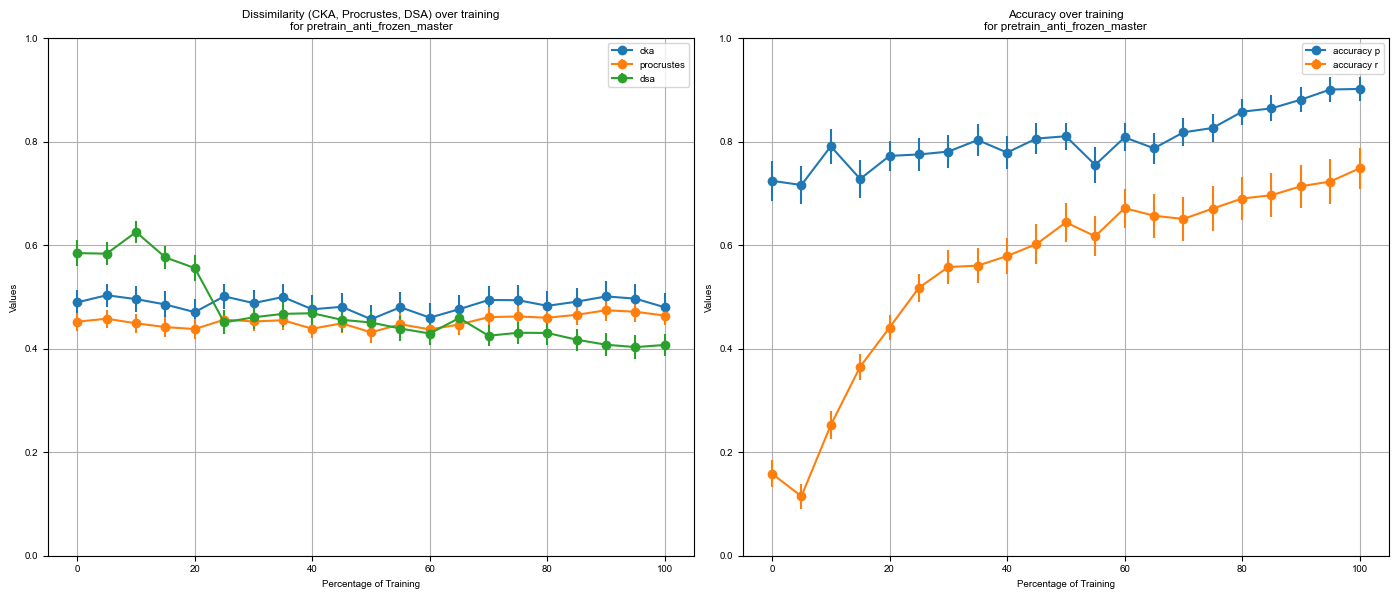

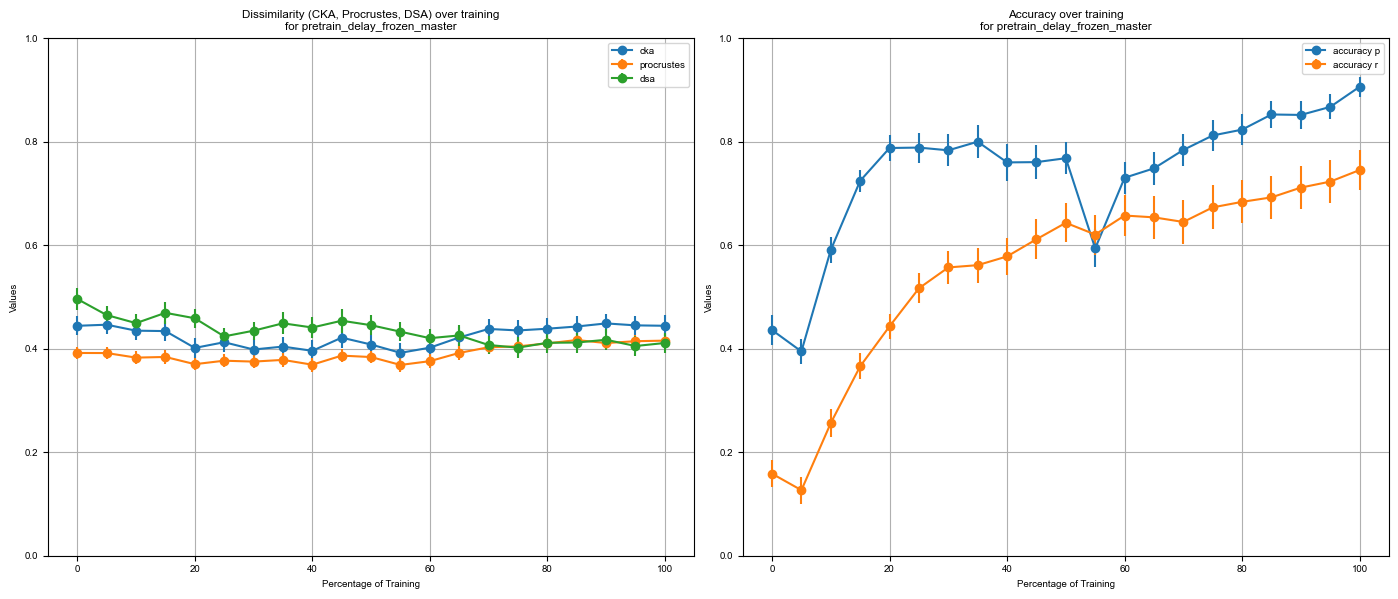

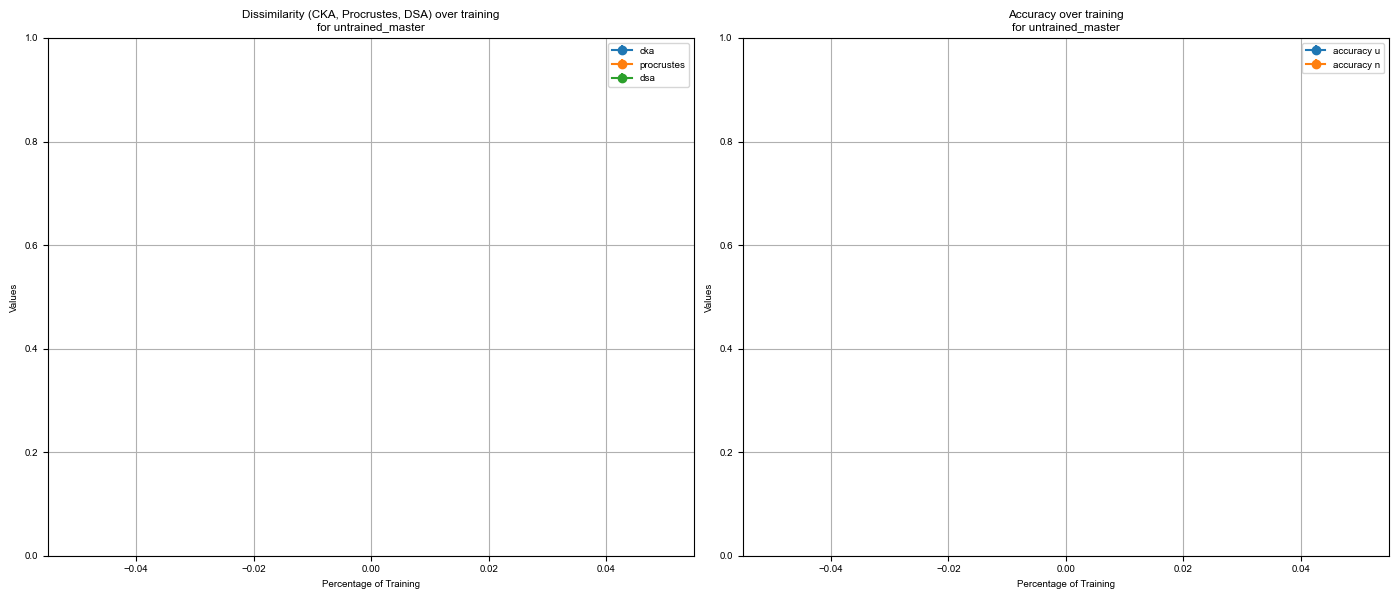

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 5 for i in range(21)]

        # Measures for the two plots
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Create the figure and the two subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

        # Plot for the first set of measures
        for key in measures_plot1:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            axs[0].errorbar(
                x_values,
                list([value[0] for value in dict_sampling_to_mean_and_errors.values()]),
                yerr=[value[1] for value in dict_sampling_to_mean_and_errors.values()],
                marker="o",
                label=key,
            )

        axs[0].set_xlabel("Percentage of Training")
        axs[0].set_ylabel("Values")
        axs[0].set_title(
            "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
                group_training
            )
        )
        axs[0].set_ylim(0, 1)
        axs[0].legend()
        axs[0].grid(True)

        # Plot for the second set of measures
        for i, key in enumerate(measures_plot2):
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            # Rename legend label for accuracy
            label = f"accuracy {group_training[i]}"
            axs[1].errorbar(
                x_values,
                list([value[0] for value in dict_sampling_to_mean_and_errors.values()]),
                yerr=[value[1] for value in dict_sampling_to_mean_and_errors.values()],
                marker="o",
                label=label,
            )

        axs[1].set_xlabel("Percentage of Training")
        axs[1].set_ylabel("Values")
        axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
        axs[1].set_ylim(0, 1)
        axs[1].legend()
        axs[1].grid(True)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plots
        plt.show()

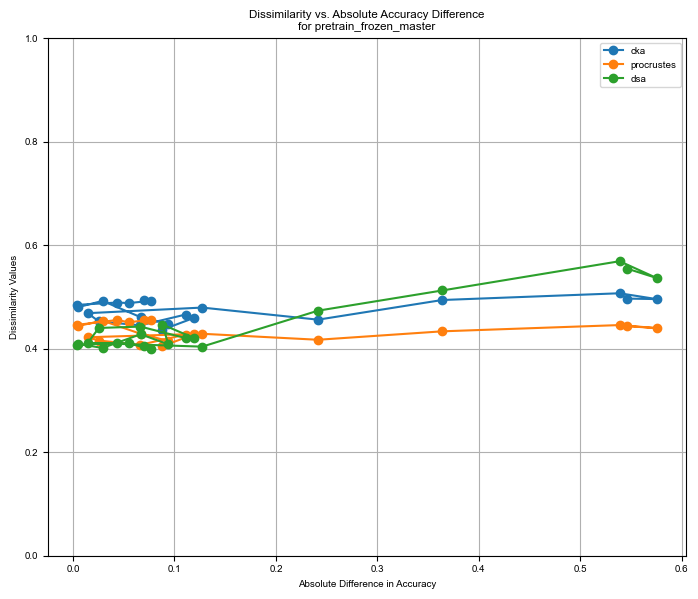

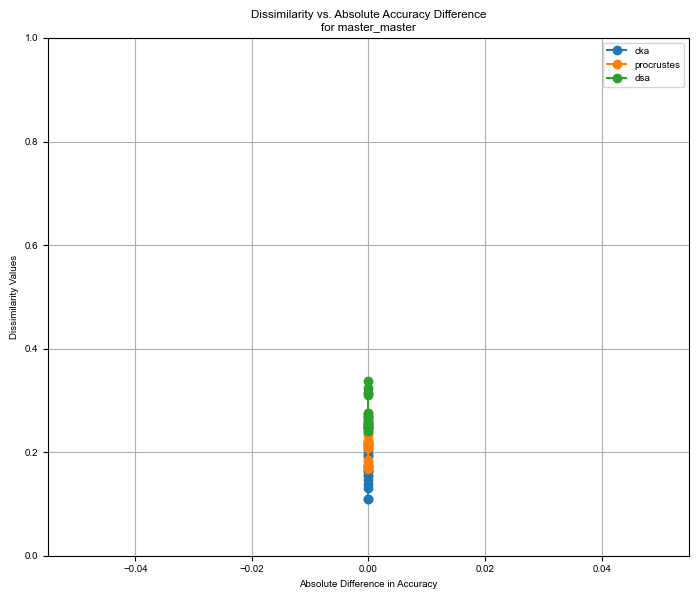

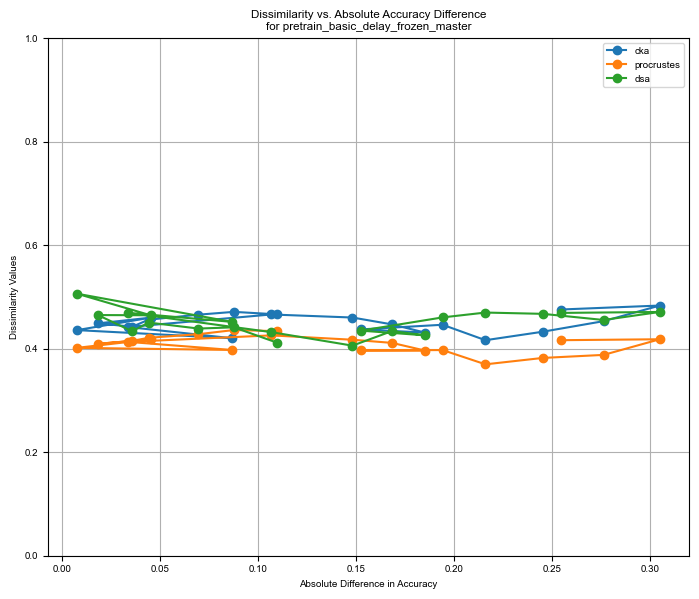

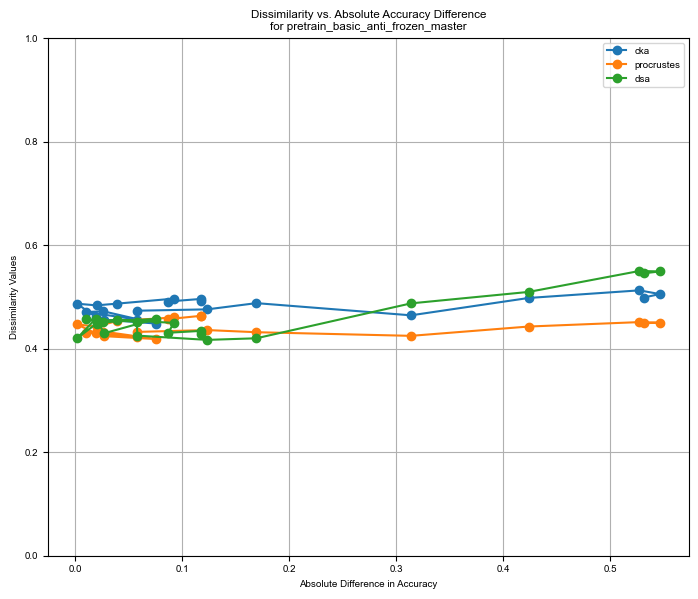

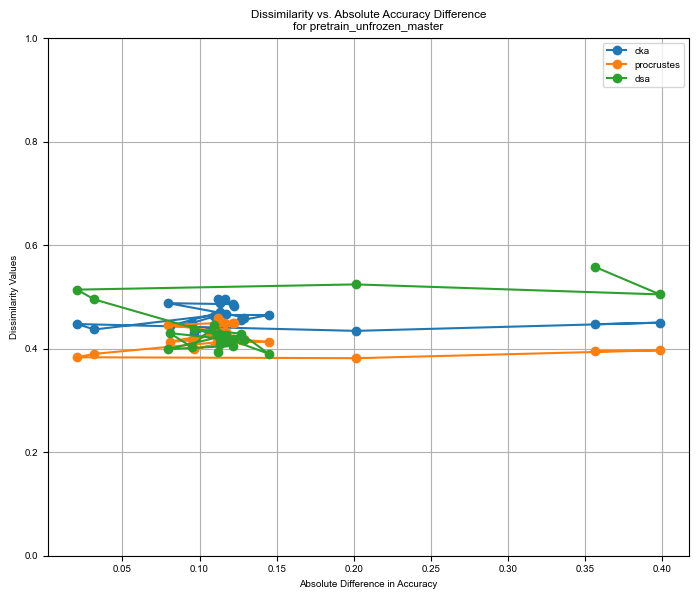

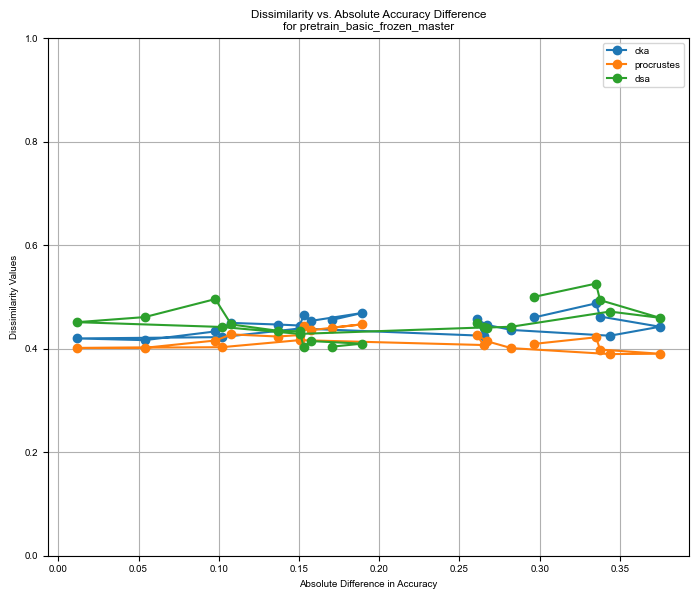

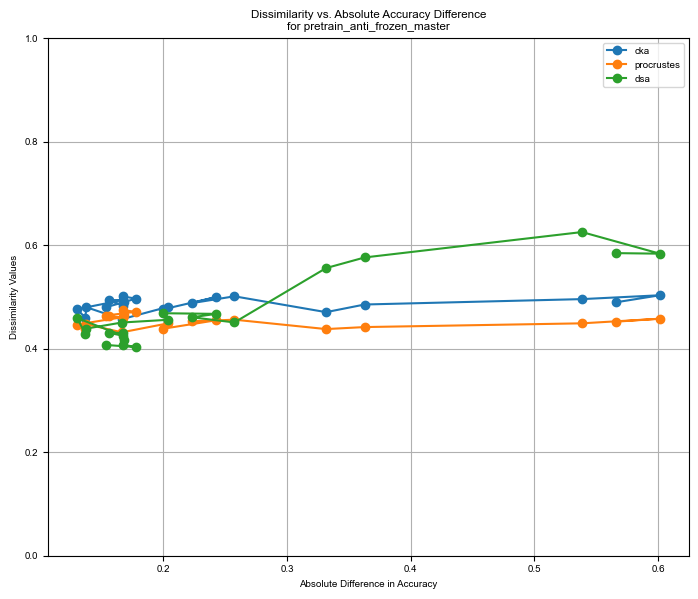

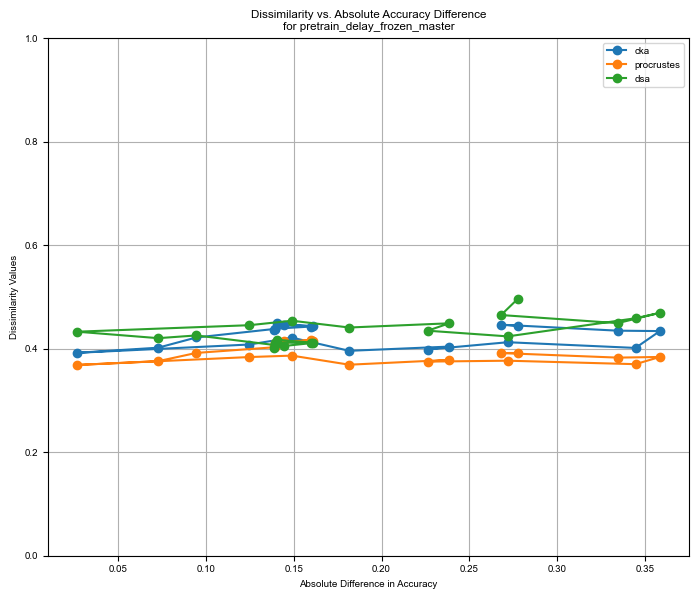

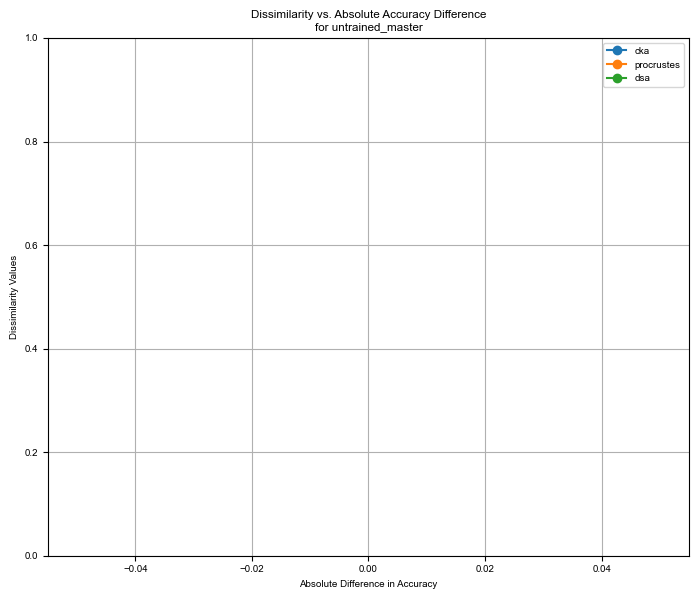

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    if "master_frozen" not in group_training:
        dissimilarities_interpolated = dissimilarities_groups[group_training]

        # X-axis values
        x_values = [i * 5 for i in range(21)]

        # Measures for dissimilarities and accuracies
        measures_plot1 = ["cka", "procrustes", "dsa"]
        measures_plot2 = ["accuracy_1", "accuracy_2"]

        # Collect accuracy values to calculate absolute differences
        accuracy_values = {}
        for key in measures_plot2:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            accuracy_values[key] = list(
                [value[0] for value in dict_sampling_to_mean_and_errors.values()]
            )

        # Calculate the absolute difference between the two accuracy measures
        abs_diff_accuracies = np.abs(
            np.array(accuracy_values["accuracy_1"])
            - np.array(accuracy_values["accuracy_2"])
        )

        # Create the figure and plot the third subplot
        fig, ax = plt.subplots(figsize=(7, 6))  # Single subplot

        # Plot the dissimilarities against the absolute accuracy difference
        for key in measures_plot1:
            dict_sampling_to_mean_and_errors = dissimilarities_interpolated[key]
            dissimilarity_values = list(
                [value[0] for value in dict_sampling_to_mean_and_errors.values()]
            )
            ax.plot(
                abs_diff_accuracies,
                dissimilarity_values,
                marker="o",
                label=key,
            )

        ax.set_xlabel("Absolute Difference in Accuracy")
        ax.set_ylabel("Dissimilarity Values")
        ax.set_title(
            "Dissimilarity vs. Absolute Accuracy Difference\nfor {}".format(
                group_training
            )
        )
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)

        # Adjust layout to avoid overlapping elements
        plt.tight_layout()

        # Display the plot
        plt.show()

In [28]:
group_pairs_master = find_group_pairs_master(config, taskset)
diss_cc = get_dissimilarities_shared_task_shared_curriculum(
    group_pairs_master, dissimilarities_groups, x_values
)

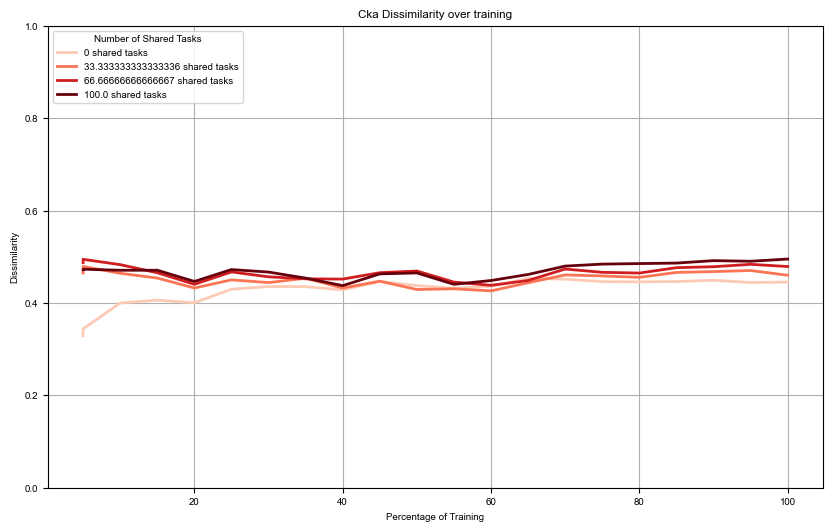

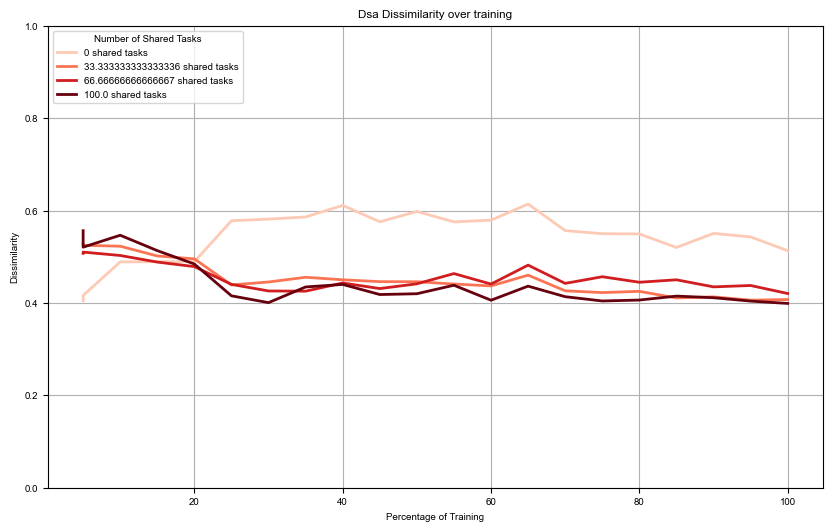

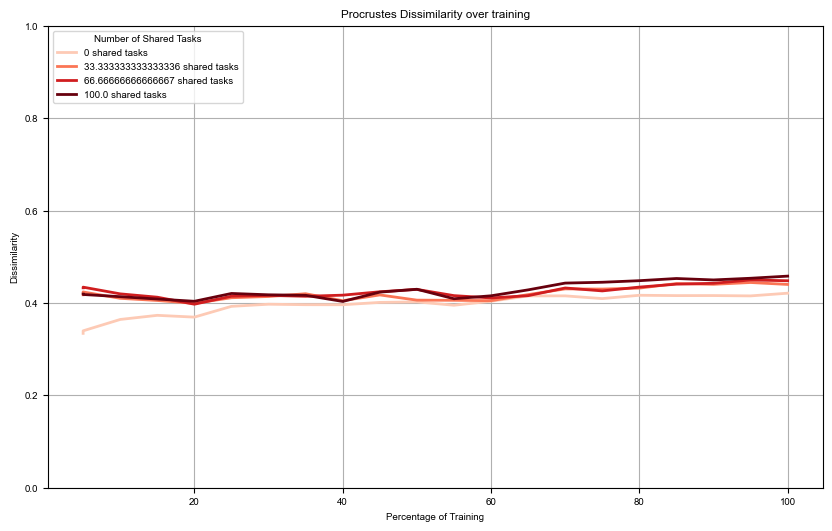

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Normalize the number of shared tasks to range between a small positive value and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Set a small offset to avoid using the lightest color for 0 shared tasks
offset = 0.2  # This will push the normalization slightly to the right

# Create a colormap ranging from light to dark red
cmap = cm.Reds

# Plot each measure
for measure in diss_cc:
    plt.figure(figsize=(10, 6))  # Create a new figure for each measure
    handles = []
    labels = []

    for shared in sorted(
        diss_cc[measure].keys()
    ):  # Sort by shared tasks for plotting and legend ordering
        x_new, y_new = diss_cc[measure][shared]

        # Normalize shared task count to get a color, with the offset to avoid very light colors
        norm_shared = offset + (shared - min_shared) / (max_shared - min_shared) * (
            1 - offset
        )
        color = cmap(norm_shared)  # Get the color from the colormap

        # Plot with the determined color
        (line,) = plt.plot(
            [5]+x_new[1:], y_new, label=f"{shared} shared tasks", color=color, linewidth=2
        )
        handles.append(line)
        labels.append(f"{shared} shared tasks")

    # Reorder the legend according to the number of shared tasks
    plt.legend(
        handles=handles, labels=labels, title="Number of Shared Tasks", loc="upper left"
    )

    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.grid(True)
    plt.show()

### Dissimilarity within group 

In [30]:
path = f"../data/dissimilarities_within_learning/{taskset}/pretrain_frozen"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            with np.load(file_path) as data:
                dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.median(np.stack(value, axis=0), axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dissimilarities_within_learning/PDM/pretrain_frozen/cka'

In [ ]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()

IndexError: Inconsistent shape between the condition and the input (got (0, 1) and (0,))

<Figure size 1000x600 with 0 Axes>